In [1]:
1./3

0.3333333333333333

In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import cPickle
from cuisinify import cuisinify
import seaborn as sns
from IPython.display import Image
from IPython.core.display import HTML 
import spacy
import os
from spacy.en import English
from matplotlib import gridspec
from matplotlib import cm
from sklearn.cross_validation import KFold, cross_val_score, train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, \
    ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor, BaggingRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, recall_score, precision_score, accuracy_score, \
    roc_auc_score, roc_curve
from sklearn.metrics import classification_report
import matplotlib.patheffects as path_effects
from sklearn.grid_search import GridSearchCV, RandomizedSearchCV
from scipy.stats import randint
import time
from operator import itemgetter

%matplotlib inline

In [29]:
df = cPickle.load(open('assets/big_df_model-ready.p', 'rb'))

In [30]:
df.head(1)

,name,cuisine,blurb,currency,photos,add_info,num_words,photo_count,latitude,longitude,...,dinner_only,wheelchair,private_dining,with_rooms,booking,lunch_only,tennis,dinner_tasting,valet,adj_standing
0,Bellevue,Catalan,Now here is a delicious find! The menu positiv...,EUR,[https://download.viamichelin.com/media/image/...,"[Lunch 20 €, Menu 32/56 € - Carte 45/58 €, Mea...",46,6,42.40434,2.479931,...,0,0,0,0,0,0,0,0,0,13


In [31]:
df.columns

Index([u'name', u'cuisine', u'blurb', u'currency', u'photos', u'add_info',
       u'num_words', u'photo_count', u'latitude', u'longitude', u'name_len',
       u'avg_USD', u'standing', u'stars', u'bib', u'included', u'assiette',
       u'value_menu', u'BRL', u'CHF', u'CZK', u'DKK', u'EUR', u'GBP', u'HKD',
       u'HUF', u'MOP', u'NOK', u'PLN', u'SEK', u'SGD', u'USD',
       u'span class=wine', u'english+french-', u'old-ie.js', u'wine', u'view',
       u'garden', u'outside_dining', u'air_conditioning', u'no_dogs',
       u'parking', u'dinner_only', u'wheelchair', u'private_dining',
       u'with_rooms', u'booking', u'lunch_only', u'tennis', u'dinner_tasting',
       u'valet', u'adj_standing'],
      dtype='object')

In [32]:
location = cPickle.load(open('assets/location.p', 'rb'))
new_location = []
for i in location:
    if not i:
        new_location.append({})
    else:
        new_location.append(i)
        
location = pd.DataFrame(new_location)
location = location.drop(location.index[[1686, 3475, 5122, 15338, 16273, 17939, 18013, \
                                         18147, 18665]])
location = location.reset_index(drop = True)

In [33]:
if len(df) == len(location):
    location = pd.DataFrame(location)
    df = pd.concat([df, location], axis = 1)
else:
    print 'length does not match'

Slice out box containing NYC latitude and longitude limits:

In [34]:
df = df[(df['longitude'] > -74.4) & \
            (df['longitude'] < -73.6) & (df['latitude'] > 40.4) & \
            (df['latitude'] < 41)]
df.reset_index(drop = True, inplace = True)

In [35]:
df[['name', 'cuisine', 'blurb', 'display_name']].tail(1)

,name,cuisine,blurb,display_name
872,Paet Rio,Thai,"With so many Thai places around, it's easy to ...","81-01, Broadway, Elmhurst, Queens County, NYC,..."


Address of final observation is correct!  Hooray!  We picked up some other dictionary keys along the way that became columns, let's check them out:

In [36]:
len(df['osm_id'].value_counts())

847

In [37]:
df['osm_type'].value_counts()

way         704
node        164
relation      5
Name: osm_type, dtype: int64

In [38]:
len(df['place_id'].value_counts())

847

In [39]:
df['licence'].value_counts()

Data © OpenStreetMap contributors, ODbL 1.0. http://www.openstreetmap.org/copyright    873
Name: licence, dtype: int64

Let's keep 'osm_type' as a feature and dummify it later, just for fun.

In [40]:
df = df.drop(df[['boundingbox', 'display_name', 'error', 'lat', 'licence', 'lon', 'osm_id', \
                'place_id']], axis = 1)

In [41]:
address_list = []
for i in range(len(df)):
    x = len(df['address'][i])
    address_list.append(x)
set(address_list)

{8, 9, 10, 11}

In [42]:
count = [0]*4
for i in range(len(df)):
    if len(df['address'][i]) == 8:
        count[0] += 1
        print df['address'][i]
        print '\n'
    elif len(df['address'][i]) == 9:
        count[1] += 1
    elif len(df['address'][i]) == 10:
        count[2] += 1
    else:
        count[3] += 1
        
count

{u'city': u'NYC', u'house_number': u'112', u'country': u'United States of America', u'county': u'Kings County', u'state': u'New York', u'postcode': u'11237', u'country_code': u'us', u'road': u'Harrison Place'}


{u'city': u'NYC', u'house_number': u'436', u'country': u'United States of America', u'county': u'Kings County', u'state': u'New York', u'postcode': u'11237', u'country_code': u'us', u'road': u'Jefferson Street'}




[2, 152, 618, 101]

In [43]:
ZIP = []
for i in range(len(df)):
    try:
        x = df['address'][i]['postcode']
        ZIP.append(x)
    except:
        ZIP.append(None)
        
df['ZIP'] = ZIP
del ZIP
del df['address']

In [44]:
for i in range(len(df)):
    if len(df['ZIP'][i]) != 5:
        print type(df['ZIP'][i]), '\'' + str(df['ZIP'][i]) + '\''

<type 'unicode'> '83'
<type 'unicode'> '10035; 10027'
<type 'unicode'> '10035; 10027'


In [45]:
df[df['ZIP'] == u'83'][['name', 'cuisine']]

,name,cuisine
198,Boathouse Central Park,American


In [46]:
df[df['ZIP'] == u'10035; 10027'][['name', 'cuisine']]

,name,cuisine
522,Red Rooster,American
675,Corner Social,American


In [47]:
df['ZIP'][198] = '10021'
df['ZIP'][522] = '10027'
df['ZIP'][675] = '10027'

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [48]:
len(df['ZIP'].value_counts())

106

In [49]:
df.columns

Index([            u'name',          u'cuisine',            u'blurb',
               u'currency',           u'photos',         u'add_info',
              u'num_words',      u'photo_count',         u'latitude',
              u'longitude',         u'name_len',          u'avg_USD',
               u'standing',            u'stars',              u'bib',
               u'included',         u'assiette',       u'value_menu',
                    u'BRL',              u'CHF',              u'CZK',
                    u'DKK',              u'EUR',              u'GBP',
                    u'HKD',              u'HUF',              u'MOP',
                    u'NOK',              u'PLN',              u'SEK',
                    u'SGD',              u'USD',  u'span class=wine',
        u'english+french-',        u'old-ie.js',             u'wine',
                   u'view',           u'garden',   u'outside_dining',
       u'air_conditioning',          u'no_dogs',          u'parking',
            u'dinner

In [50]:
df_NYC = df[['name', 'cuisine', 'blurb', 'ZIP', 'latitude', 'longitude', 'avg_USD', \
             'stars', 'bib', 'assiette', 'wine', 'view', 'garden', 'outside_dining', \
             'air_conditioning', 'no_dogs', 'parking', 'dinner_only', 'wheelchair', \
             'private_dining', 'with_rooms', 'booking', 'lunch_only', 'dinner_tasting', \
             'valet']]
df_NYC.to_csv('assets/df_NYC.csv', index = False, encoding='utf-8')

In [51]:
df_incl = df[df['included'] == 1]
df_bib = df[df['bib'] == 1]
df_1 = df[df['stars'] == 1]
df_2 = df[df['stars'] == 2]
df_3 = df[df['stars'] == 3]

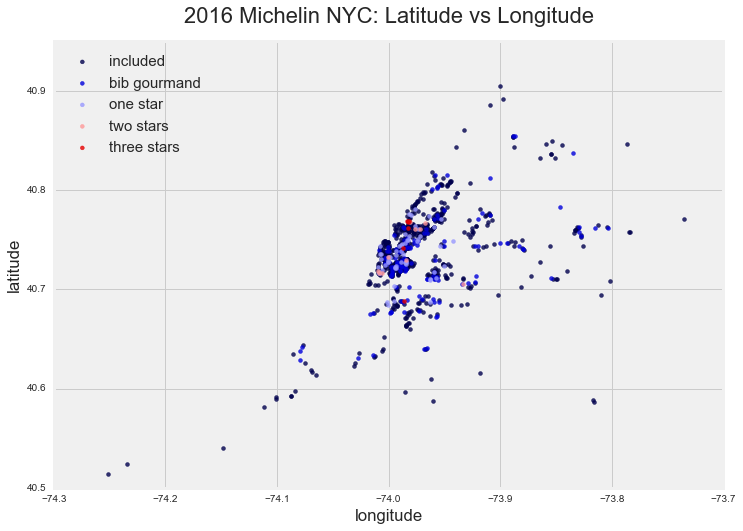

In [52]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

distinction_colors = []
for i in range(0, 256, 256/5):
    distinction_colors.append(cm.seismic(i))

plt.scatter(df_incl['longitude'], df_incl['latitude'], color = distinction_colors[0], \
            alpha = 0.8, s = 15, label = 'included')
plt.scatter(df_bib['longitude'], df_bib['latitude'], color = distinction_colors[1], \
            alpha = 0.8, s = 15, label = 'bib gourmand')
plt.scatter(df_1['longitude'], df_1['latitude'], color = distinction_colors[2], \
            alpha = 0.8, s = 15, label = 'one star')
plt.scatter(df_2['longitude'], df_2['latitude'], color = distinction_colors[3], \
            alpha = 0.8, s = 15, label = 'two stars')
plt.scatter(df_3['longitude'], df_3['latitude'], color = distinction_colors[4], \
            alpha = 0.8, s = 15, label = 'three stars')

plt.title('2016 Michelin NYC: Latitude vs Longitude', fontsize = 22, y = 1.03)

# y label
plt.ylabel('latitude')

# x label
plt.xlabel('longitude')

# set the figure boundaries
plt.ylim([40.5, 40.95])
plt.xlim([-74.3, -73.7])
plt.grid(True)
plt.legend(loc='upper left', fontsize = 15)

plt.show()

In [53]:
cuisinify(df)

,name,cuisine,blurb,currency,photos,add_info,num_words,photo_count,latitude,longitude,...,with_rooms,booking,lunch_only,tennis,dinner_tasting,valet,adj_standing,osm_type,ZIP,new_cuisine
0,Joe & MissesDoe,Contemporary,Chef Joe and Jill Doe have revamped their earn...,USD,[],"[$25 to $50, Brunch, Address 45 E. 1st St., Ne...",120,0,40.723790,-73.989690,...,0,0,0,0,0,0,12,way,10003,contemporary
1,East 12th Osteria,Italian,"On the one hand, this is a straightforward lit...",USD,[],"[$25 to $50, Brunch, Address 197 First Ave., N...",121,0,40.730140,-73.983580,...,0,0,0,0,0,0,13,way,10003,italian
2,Pagani,Italian,"With witty cocktails, cured meats, and rustico...",USD,[],"[$25 to $50, Wheelchair accessible, Brunch, Ad...",113,0,40.732143,-74.003480,...,0,0,0,0,0,0,13,way,10014,italian
3,Armani Ristorante,Italian,At Giorgio Armani's Fifth Avenue restaurant wh...,USD,[],"[$50 to $75, Wheelchair accessible, Brunch, Ad...",121,0,40.762127,-73.974144,...,0,0,0,0,0,0,13,way,10022,italian
4,Emilio's Ballato,Italian,This unassuming Houston St. standard is an uns...,USD,[],"[$25 to $50, Private dining rooms, Address 55 ...",113,0,40.724620,-73.994470,...,0,0,0,0,0,0,13,node,10012,italian
5,Khe-Yo,Asian,This Laotian hot spot serves up vibrant family...,USD,[],"[$25 to $50, Brunch, Address 157 Duane St., Ne...",127,0,40.716835,-74.008790,...,0,0,0,0,0,0,13,way,10013,asian
6,Atrium,Contemporary,This industrial bi-level space has a rather ic...,USD,[],"[$50 to $75, Wheelchair accessible, Brunch, A ...",111,0,40.703716,-73.990590,...,0,0,0,0,0,0,13,way,11201,contemporary
7,Tong Sam Gyup Goo Yi,Korean,"Murray Hill is no stranger to Korean food, but...",USD,[],"[$25 to $50, No credit cards, Address 162-23 D...",121,0,40.762066,-73.803024,...,0,0,0,0,0,0,12,way,11358,korean
8,Toro,Spanish,"Trendy location? Check. Sleek, warehouse-sized...",USD,[],"[$25 to $50, Notable cocktail list, Eat Late, ...",117,0,40.743130,-74.007675,...,0,0,0,0,0,0,13,node,10011,spanish
9,Narcissa,Contemporary,André Balaz's Standard East Village hotel is w...,USD,[],"[$25 to $50, Meals outside, Brunch, Address 21...",117,0,40.728060,-73.990900,...,0,0,0,0,0,0,13,way,10003,contemporary


In [54]:
df['adj_standing'] = [None]*len(df)
df['adj_standing'][df['standing'] == 12] = 12
df['adj_standing'][df['standing'] == 13] = 13
df['adj_standing'][df['standing'] == 14] = 14
df['adj_standing'][df['standing'] == 15] = 15
df['adj_standing'][df['standing'] == 16] = 16
df['adj_standing'][df['standing'] == 17] = 12.5
df['adj_standing'][df['standing'] == 18] = 13.5
df['adj_standing'][df['standing'] == 19] = 14.5
df['adj_standing'][df['standing'] == 20] = 15.5
df['adj_standing'][df['standing'] == 21] = 16.5

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipyker

In [55]:
df.isnull().sum()[df.isnull().sum() != 0]

standing        16
adj_standing    16
dtype: int64

In [56]:
df[df['adj_standing'].isnull()][['name']]

,name
73,Pickle Shack
301,Las Ramblas
368,Tía Pol
372,Casellula
376,Bin 71
388,ChikaLicious
391,Rockmeisha
416,Clover Club
438,Mimi's Hummus
480,Kirakuya


We'll take these out at least for EDA, but since 'adj_standing' probably won't be a feature in the models -- its value is only known once the target ('stars') is known so is not useful in predicting -- we'll probably add them back in later.

In [57]:
df = df.dropna(subset = ['adj_standing'])
df.reset_index(drop = True, inplace = True)

In [58]:
## remove columns summing to zero
df = df.loc[:, (df.sum(axis=0) != 0)]

In [59]:
df.columns

Index([           u'name',         u'cuisine',           u'blurb',
              u'currency',          u'photos',        u'add_info',
             u'num_words',     u'photo_count',        u'latitude',
             u'longitude',        u'name_len',         u'avg_USD',
              u'standing',           u'stars',             u'bib',
              u'included',             u'USD', u'span class=wine',
       u'english+french-',       u'old-ie.js',            u'wine',
        u'outside_dining',         u'parking',      u'wheelchair',
        u'private_dining',           u'valet',    u'adj_standing',
              u'osm_type',             u'ZIP',     u'new_cuisine'],
      dtype='object')

We took out some observations, so let's redefine these subset dataframes spanning df:

In [60]:
df_incl = df[df['included'] == 1]
df_bib = df[df['bib'] == 1]
df_1 = df[df['stars'] == 1]
df_2 = df[df['stars'] == 2]
df_3 = df[df['stars'] == 3]

A handy-dandy pair of jittering functions to keep in our pocket:

In [61]:
## define jitter functions 
def rand_jitter(arr):
    stdev = .005*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev   

def more_rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev  

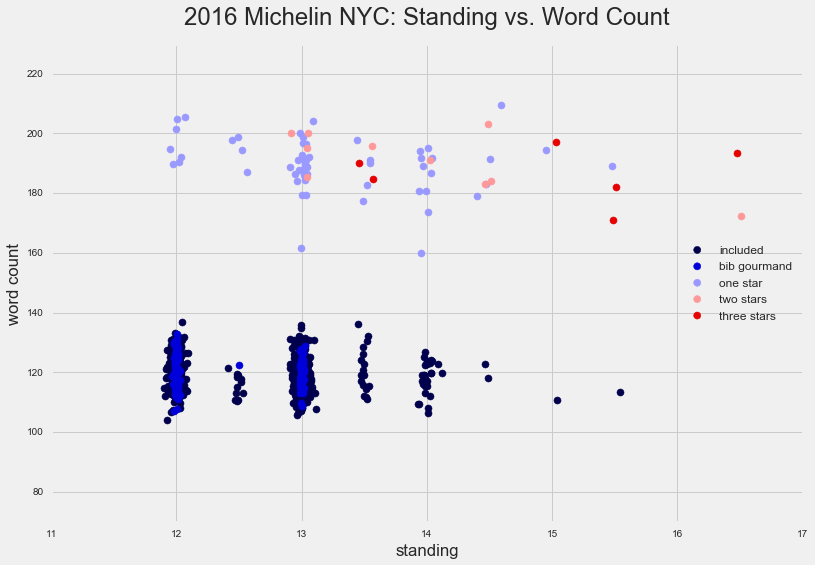

In [62]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

distinction_colors = []
for i in range(0, 256, 256/5):
    distinction_colors.append(cm.seismic(i))


plt.scatter(more_rand_jitter(df_incl['adj_standing']), \
            more_rand_jitter(df_incl['num_words']), \
            color = distinction_colors[0], \
            alpha = 1, s = 50, label = 'included')

plt.scatter(more_rand_jitter(df_bib['adj_standing']), \
            more_rand_jitter(df_bib['num_words']), \
            color = distinction_colors[1], \
            alpha = 1, s = 50, label = 'bib gourmand')

plt.scatter(more_rand_jitter(df_1['adj_standing']), more_rand_jitter(df_1['num_words']), \
            color = distinction_colors[2], alpha = 1, s = 50, label = 'one star')

plt.scatter(more_rand_jitter(df_2['adj_standing']), more_rand_jitter(df_2['num_words']), \
            color = distinction_colors[3], alpha = 1, s = 50, label = 'two stars')

plt.scatter(more_rand_jitter(df_3['adj_standing']), more_rand_jitter(df_3['num_words']),\
            color = distinction_colors[4], alpha = 1, s = 50, label = 'three stars')



plt.title('2016 Michelin NYC: Standing vs. Word Count', fontsize = 24, y = 1.03)

# y label
plt.ylabel('word count')

# x label
plt.xlabel('standing')

# set the figure boundaries
plt.xlim([min(df['adj_standing']) - 1, max(df['adj_standing'] + 0.5)])
plt.ylim(70, 230)
plt.grid(True)
plt.legend(loc='center right', fontsize = 12)

plt.show()

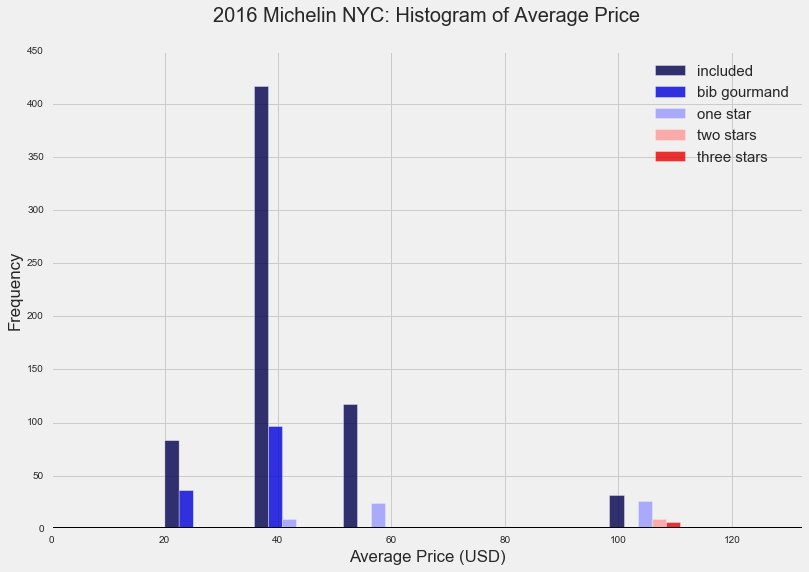

In [63]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

# fig, axis = plt.subplots(2, 1, sharex = True)

df_hist = plt.hist([df_incl['avg_USD'], \
                    df_bib['avg_USD'], \
                    df_1['avg_USD'], \
                    df_2['avg_USD'], \
                    df_3['avg_USD']], \
                    bins = 6, alpha = 0.8, stacked = False, \
                    color = [distinction_colors[0], \
                            distinction_colors[1], \
                            distinction_colors[2], \
                            distinction_colors[3], \
                            distinction_colors[4]], \
                    label = ['included', \
                             'bib gourmand', \
                             'one star', \
                             'two stars', \
                             'three stars'])

plt.axhline(0, color='black')
plt.title('2016 Michelin NYC: Histogram of Average Price', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Average Price (USD)')

plt.xlim([0, max(df['avg_USD'] + 20)])
plt.ylim([0, 450])

plt.legend(loc='upper right', fontsize = 15)

plt.show()

Broken axis code in the cell below adapted from:

http://matplotlib.org/1.5.1/examples/pylab_examples/broken_axis.html

(This is under construction!)

In [64]:
# plt.style.use('fivethirtyeight')

# fig = plt.figure(figsize=(12, 8)) 

# gs = gridspec.GridSpec(2, 1, width_ratios = [1, 1], height_ratios = [20, 120]) 

# ## top plot
# ax0 = plt.subplot(gs[0])
# ax0.hist([df_incl['avg_USD'], \
#                     df_bib['avg_USD'], \
#                     df_1['avg_USD'], \
#                     df_2['avg_USD'], \
#                     df_3['avg_USD']], \
#                     bins = 6, alpha = 0.8, stacked = False, \
#                     color = [distinction_colors[0], \
#                             distinction_colors[1], \
#                             distinction_colors[2], \
#                             distinction_colors[3], \
#                             distinction_colors[4]], \
#                     label = ['included', \
#                              'bib gourmand', \
#                              'one star', \
#                              'two stars', \
#                              'three stars'])
# ## bottom plot
# ax1 = plt.subplot(gs[1])
# ax1.hist([df_incl['avg_USD'], \
#                     df_bib['avg_USD'], \
#                     df_1['avg_USD'], \
#                     df_2['avg_USD'], \
#                     df_3['avg_USD']], \
#                     bins = 6, alpha = 0.8, stacked = False, \
#                     color = [distinction_colors[0], \
#                             distinction_colors[1], \
#                             distinction_colors[2], \
#                             distinction_colors[3], \
#                             distinction_colors[4]], \
#                     label = ['included', \
#                              'bib gourmand', \
#                              'one star', \
#                              'two stars', \
#                              'three stars'])

# # zoom-in / limit the view to different portions of the data
# ax0.set_ylim(400, 420)  # outliers only
# ax1.set_ylim(0, 120)   # most of the data 
# ax1.set_xlim(0, 120)
# ax0.set_xlim(0, 120)
# # hide the spines between ax and ax2
# ax0.spines['bottom'].set_visible(False)
# ax1.spines['top'].set_visible(False)
# ax0.xaxis.tick_top()
# ax0.tick_params(labeltop='off')  # don't put tick labels at the top
# ax1.xaxis.tick_bottom()

# # d = .015  # how big to make the diagonal lines in axes coordinates
# # # arguments to pass plot, just so we don't keep repeating them
# # kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
# # ax0.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# # ax0.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal

# # kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# # ax1.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# # ax1.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)

# plt.axhline(0, color='black')

# ax0.set_title('2016 Michelin NYC: Histogram of Average Price', fontsize = 20, y = 1.05)

# # y label
# plt.ylabel('Frequency')

# # x label
# plt.xlabel('Average Price (USD)')

# # plt.xlim([0, max(df['avg_USD'] + 20)])
# # plt.ylim([0, 450])

# ax1.legend(loc='upper right', fontsize = 12)

# gs.tight_layout(fig)

# plt.show()

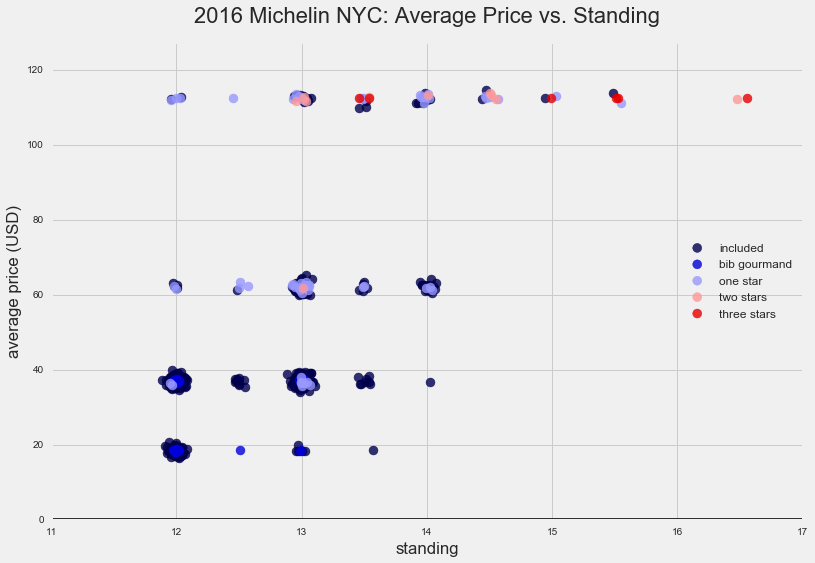

In [65]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(more_rand_jitter(df_incl['adj_standing']), more_rand_jitter(df_incl['avg_USD']), \
color = distinction_colors[0], alpha = 0.8, s = 80, label = 'included')

plt.scatter(more_rand_jitter(df_bib['adj_standing']), more_rand_jitter(df_bib['avg_USD']), \
color = distinction_colors[1], alpha = 0.8, s = 80, label = 'bib gourmand')

plt.scatter(more_rand_jitter(df_1['adj_standing']), more_rand_jitter(df_1['avg_USD']), \
color = distinction_colors[2], alpha = 0.8, s = 80, label = 'one star')

plt.scatter(more_rand_jitter(df_2['adj_standing']), more_rand_jitter(df_2['avg_USD']), \
color = distinction_colors[3], alpha = 0.8, s = 80, label = 'two stars')

plt.scatter(more_rand_jitter(df_3['adj_standing']), more_rand_jitter(df_3['avg_USD']), \
color = distinction_colors[4], alpha = 0.8, s = 80, label = 'three stars')

plt.axhline(0, color='black', alpha = 0.8)

plt.title('2016 Michelin NYC: Average Price vs. Standing', fontsize = 22, y = 1.03)

# y label
plt.ylabel('average price (USD)')

# x label
plt.xlabel('standing')

# set the figure boundaries
plt.ylim([0, max(df['avg_USD'] + 15)])
plt.xlim([11.5, 17])
plt.xticks(range(11, 18, 1))
plt.grid(True)
plt.legend(loc='center right', fontsize = 12)

plt.show()

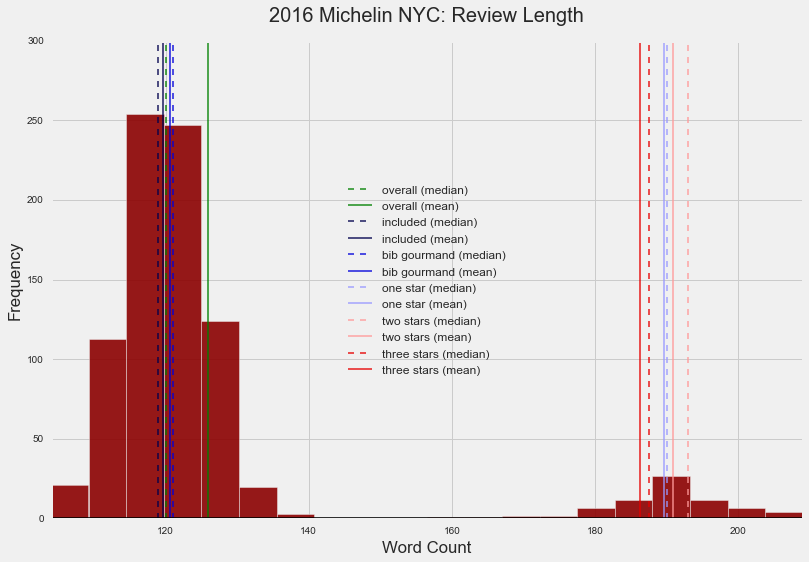

In [66]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.hist(df['num_words'], color = 'darkred', alpha = 0.9, bins = 20)
plt.axvline(df['num_words'].median(), color='green', linestyle='dashed', \
            linewidth=1.5, label = 'overall (median)', alpha = 0.9)
plt.axvline(df['num_words'].mean(), color='green', linestyle='solid', \
            linewidth=1.5, label = 'overall (mean)', alpha = 0.9)
plt.axvline(df_incl['num_words'].median(), color=distinction_colors[0], \
            linestyle='dashed', linewidth=1.5, label = 'included (median)', alpha = 0.9)
plt.axvline(df_incl['num_words'].mean(), color=distinction_colors[0], \
            linestyle='solid', linewidth=1.5, label = 'included (mean)', alpha = 0.9)
plt.axvline(df_bib['num_words'].median(), color=distinction_colors[1], \
            linestyle='dashed', linewidth=1.5, label = 'bib gourmand (median)', alpha = 0.9)
plt.axvline(df_bib['num_words'].mean(), color=distinction_colors[1], \
            linestyle='solid', linewidth=1.5, label = 'bib gourmand (mean)', alpha = 0.9)
plt.axvline(df_1['num_words'].median(), color=distinction_colors[2], \
            linestyle='dashed', linewidth=1.5, label = 'one star (median)', alpha = 0.9)
plt.axvline(df_1['num_words'].mean(), color=distinction_colors[2], \
            linestyle='solid', linewidth=1.5, label = 'one star (mean)', alpha = 0.9)
plt.axvline(df_2['num_words'].median(), color=distinction_colors[3], \
            linestyle='dashed', linewidth=1.5, label = 'two stars (median)', alpha = 0.9)
plt.axvline(df_2['num_words'].mean(), color=distinction_colors[3], \
            linestyle='solid', linewidth=1.5, label = 'two stars (mean)', alpha = 0.9)
plt.axvline(df_3['num_words'].median(), color=distinction_colors[4], \
            linestyle='dashed', linewidth=1.5, label = 'three stars (median)', alpha = 0.9)
plt.axvline(df_3['num_words'].mean(), color=distinction_colors[4], \
            linestyle='solid', linewidth=1.5, label = 'three stars (mean)', alpha = 0.9)

plt.axhline(0, color='black', alpha = 0.8)

plt.title('2016 Michelin NYC: Review Length', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Frequency')

# x label
plt.xlabel('Word Count')

plt.xlim([min(df['num_words']), max(df['num_words'])])
plt.ylim([0, 300])

plt.legend(loc='center', fontsize = 12)

plt.show()

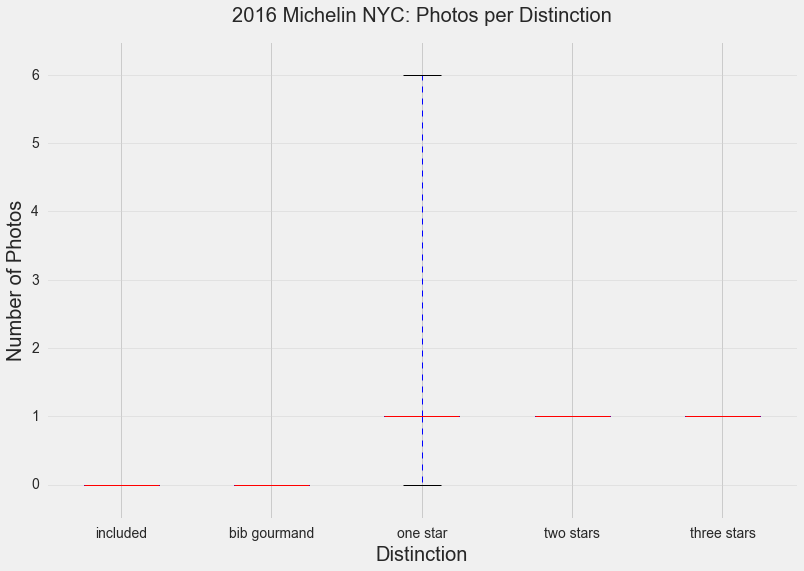

In [67]:
data_photos = [df_incl['photo_count'],
        df_bib['photo_count'],
        df_1['photo_count'],
        df_2['photo_count'], 
        df_3['photo_count']]

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust()

bp = plt.boxplot(data_photos, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('2016 Michelin NYC: Photos per Distinction', y =1.03)
ax1.set_xlabel('Distinction', fontsize = 20)
ax1.set_ylabel('Number of Photos', fontsize = 20)

# Set the axes ranges and axes labels
numBoxes = 5
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-0.5, 6.5)
xtickNames = plt.setp(ax1, xticklabels = ['included', 'bib gourmand', 'one star', \
                                          'two stars', 'three stars'])
plt.setp(xtickNames, fontsize = 14)

ytickNames = plt.setp(ax1, yticklabels = range(-1,7))
plt.setp(ytickNames, fontsize = 14)

plt.show()

In [68]:
df_1[df_1['photo_count'] > 1][['name', 'cuisine', 'ZIP', 'stars']]

,name,cuisine,ZIP,stars
616,Café China,Chinese,10016,1


In [69]:
Image(url= "https://download.viamichelin.com/media/image2/XL/F7/OC/hi/RfTViXiaYq4NHq7A.jpg")

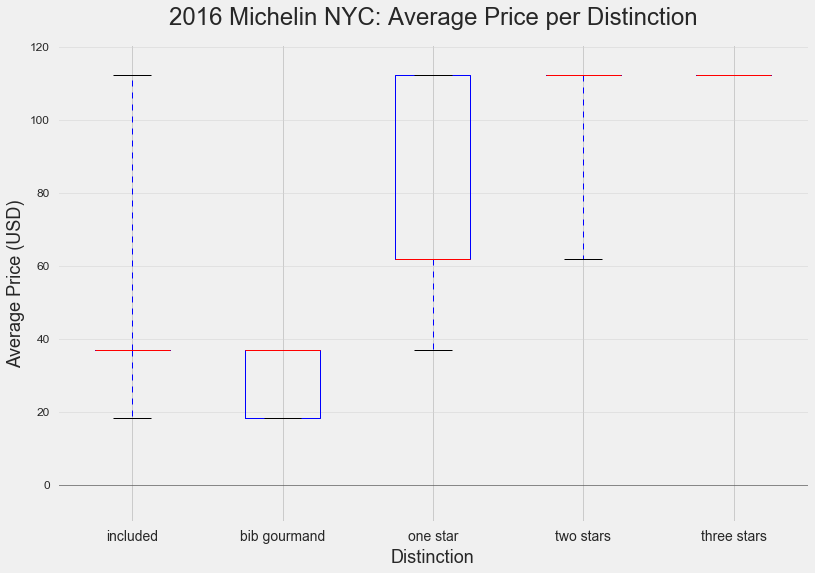

In [70]:
data_USD = [df_incl['avg_USD'], 
        df_bib['avg_USD'], 
        df_1['avg_USD'],
        df_2['avg_USD'],
        df_3['avg_USD']]

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data_USD, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('2016 Michelin NYC: Average Price per Distinction', y =1.03, fontsize = 24)
ax1.set_xlabel('Distinction', fontsize = 18)
ax1.set_ylabel('Average Price (USD)', fontsize = 18)

plt.axhline(0, color='black', alpha = 0.8, linewidth = 0.5)

# Set the axes ranges and axes labels
numBoxes = 5
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-10, 121)
xtickNames = plt.setp(ax1, xticklabels = ['included', 'bib gourmand', 'one star', 
                                          'two stars', 'three stars'])
plt.setp(xtickNames, fontsize=14)

ytickNames = plt.setp(ax1, yticklabels = range(-20, 140, 20))
plt.setp(ytickNames, fontsize=12)

plt.show()

Check out approx. what proportion of data per distinction are in the longest whisker per distinction:

In [71]:
len(df_incl[df_incl['avg_USD'] > 40])/float(len(df_incl))

0.2295839753466872

In [72]:
len(df_1[df_1['avg_USD'] < 60])/float(len(df_1))

0.15254237288135594

In [73]:
len(df_2[df_2['avg_USD'] < 110])/float(len(df_2))

0.1

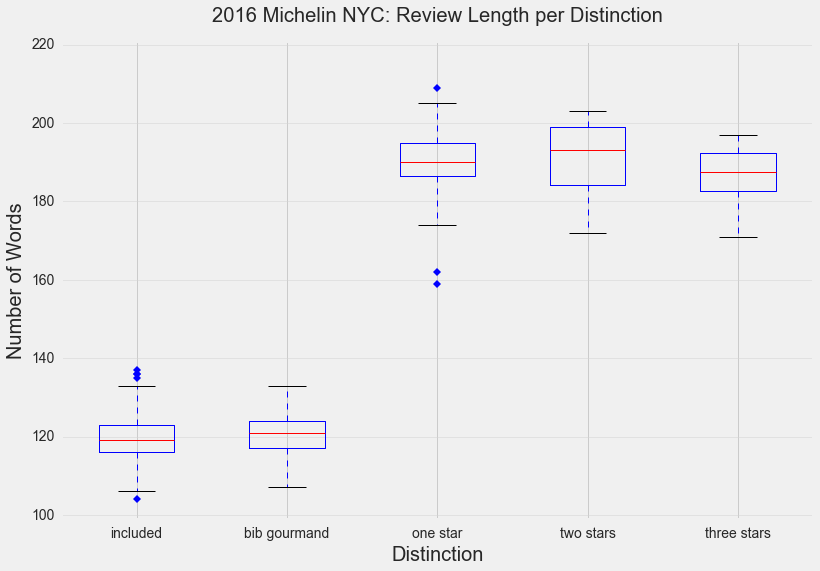

In [74]:
data_words = [df_incl['num_words'], 
        df_bib['num_words'], 
        df_1['num_words'],
        df_2['num_words'],
        df_3['num_words']]

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data_words, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('2016 Michelin NYC: Review Length per Distinction', y =1.03)
ax1.set_xlabel('Distinction', fontsize = 20)
ax1.set_ylabel('Number of Words', fontsize = 20)

plt.axhline(0, color='black', alpha = 0.8, linewidth = 0.5)

# Set the axes ranges and axes labels
numBoxes = 5
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(99, 221)
xtickNames = plt.setp(ax1, xticklabels=['included', 'bib gourmand', 'one star', \
                                        'two stars', 'three stars'])
plt.setp(xtickNames, fontsize=14)

ytickNames = plt.setp(ax1, yticklabels=range(80, 240, 20))
plt.setp(ytickNames, fontsize=14)

plt.show()

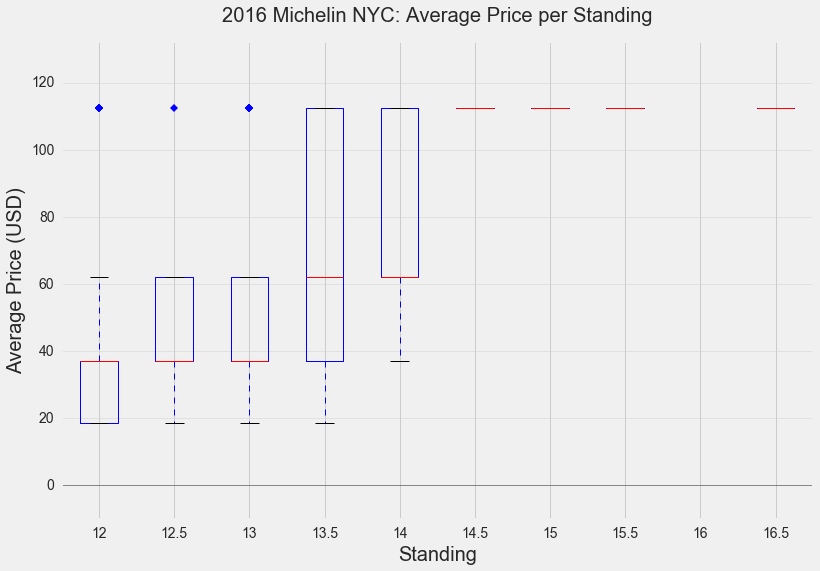

In [75]:
data_price_standing = [df[df['adj_standing'] == 12]['avg_USD'], 
        df[df['adj_standing'] == 12.5]['avg_USD'], 
        df[df['adj_standing'] == 13]['avg_USD'],
        df[df['adj_standing'] == 13.5]['avg_USD'],
        df[df['adj_standing'] == 14]['avg_USD'],
        df[df['adj_standing'] == 14.5]['avg_USD'],
        df[df['adj_standing'] == 15]['avg_USD'],
        df[df['adj_standing'] == 15.5]['avg_USD'],
        df[df['adj_standing'] == 16]['avg_USD'],
        df[df['adj_standing'] == 16.5]['avg_USD']]

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data_price_standing, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('2016 Michelin NYC: Average Price per Standing', y =1.03)
ax1.set_xlabel('Standing', fontsize = 20)
ax1.set_ylabel('Average Price (USD)', fontsize = 20)


plt.axhline(0, color='black', alpha = 0.8, linewidth = 0.5)

# Set the axes ranges and axes labels
numBoxes = 10
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-10, max(df['avg_USD']) + 20)
xtickNames = plt.setp(ax1, xticklabels=['12', '12.5', '13', '13.5', '14', '14.5', \
                                        '15', '15.5', '16', '16.5'])
plt.setp(xtickNames, fontsize=14)

ytickNames = plt.setp(ax1, yticklabels = range(-20, 140, 20))
plt.setp(ytickNames, fontsize=14)

#plt.grid(which = 'major', axis = 'x')

plt.show()

In [76]:
df[(df['adj_standing'] == 12) & (df['avg_USD'] > 70)]\
                                        [['name', 'cuisine', 'avg_USD', 'ZIP']]

,name,cuisine,avg_USD,ZIP
23,Take Root,Contemporary,112.5,11231
80,Peter Luger,Steakhouse,112.5,11211
204,Sushi of Gari,Japanese,112.5,10075
289,Sushi Sasabune,Japanese,112.5,10021
845,Kura,Japanese,112.5,10009


In [77]:
len(df[(df['adj_standing'] == 12) & (df['avg_USD'] > 70)])/\
float(len(df[df['adj_standing'] == 12]))

0.014705882352941176

In [78]:
df[(df['adj_standing'] == 12.5) & (df['avg_USD'] > 70)]\
                                        [['name', 'cuisine', 'avg_USD', 'ZIP']]

,name,cuisine,avg_USD,ZIP
750,ZZ's Clam Bar,Seafood,112.5,10012


In [79]:
len(df[(df['adj_standing'] == 12.5) & (df['avg_USD'] > 70)])/\
                                        float(len(df[df['adj_standing'] == 12.5]))

0.058823529411764705

In [80]:
df[(df['adj_standing'] == 13) & (df['avg_USD'] > 70)][['name', 'cuisine', 'ZIP']].\
sort_values(by = 'cuisine')

,name,cuisine,ZIP
142,Bobby Van's,American,10037
149,Mr Chow,Chinese,10022
342,Momofuku Ko,Contemporary,10003
751,Luksus at Tørst,Contemporary,11222
628,Blanca,Contemporary,11206
66,Racines NY,French,10007
88,da Umberto,Italian,10011
104,Babbo,Italian,10011
638,Piccola Venezia,Italian,11103
237,Bottega del Vino,Italian,10022


In [81]:
len(df[(df['adj_standing'] == 13) & (df['avg_USD'] > 70)])/\
float(len(df[(df['adj_standing'] == 13)]))

0.05542168674698795

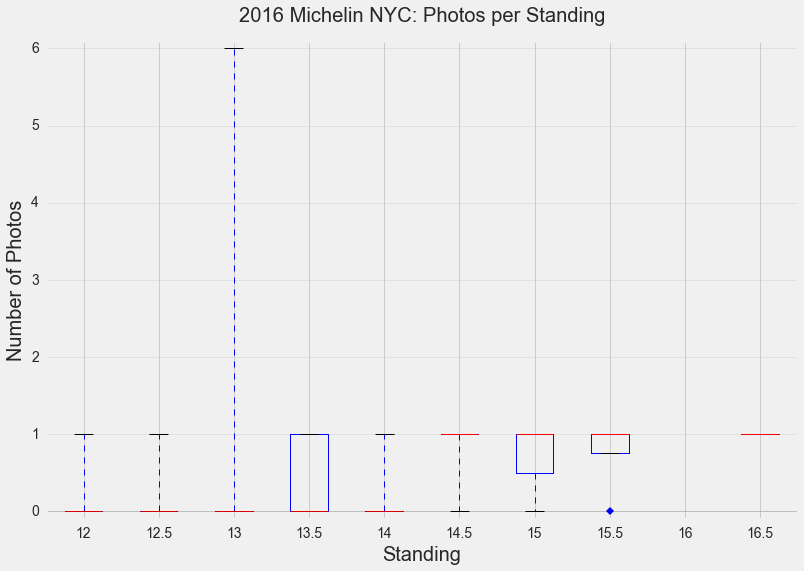

In [82]:
data_photos_standing = [df[df['adj_standing'] == 12]['photo_count'], 
        df[df['adj_standing'] == 12.5]['photo_count'], 
        df[df['adj_standing'] == 13]['photo_count'],
        df[df['adj_standing'] == 13.5]['photo_count'],
        df[df['adj_standing'] == 14]['photo_count'],
        df[df['adj_standing'] == 14.5]['photo_count'],
        df[df['adj_standing'] == 15]['photo_count'],
        df[df['adj_standing'] == 15.5]['photo_count'],
        df[df['adj_standing'] == 16]['photo_count'],
        df[df['adj_standing'] == 16.5]['photo_count']]

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data_photos_standing, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('2016 Michelin NYC: Photos per Standing', y =1.03)
ax1.set_xlabel('Standing', fontsize = 20)
ax1.set_ylabel('Number of Photos', fontsize = 20)

plt.axhline(0, color='black', alpha = 0.3, linewidth = 0.5)

# Set the axes ranges and axes labels
numBoxes = 10
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(-0.1, 6.1)
xtickNames = plt.setp(ax1, xticklabels=['12', '12.5', '13', '13.5', '14', '14.5', \
                                        '15', '15.5', '16', '16.5'])
plt.setp(xtickNames, fontsize=14)

ytickNames = plt.setp(ax1, yticklabels = range(-1, 7))
plt.setp(ytickNames, fontsize=14)

#plt.grid(which = 'major', axis = 'x')

plt.show()

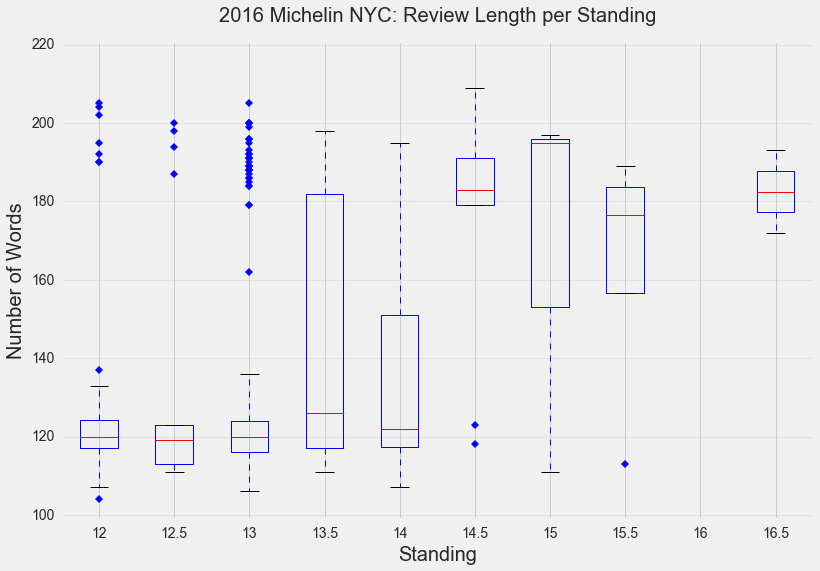

In [83]:
data_words_standing = [df[df['adj_standing'] == 12]['num_words'], 
        df[df['adj_standing'] == 12.5]['num_words'], 
        df[df['adj_standing'] == 13]['num_words'],
        df[df['adj_standing'] == 13.5]['num_words'],
        df[df['adj_standing'] == 14]['num_words'],
        df[df['adj_standing'] == 14.5]['num_words'],
        df[df['adj_standing'] == 15]['num_words'],
        df[df['adj_standing'] == 15.5]['num_words'],
        df[df['adj_standing'] == 16]['num_words'],
        df[df['adj_standing'] == 16.5]['num_words']]

plt.style.use('fivethirtyeight')
fig, ax1 = plt.subplots(figsize=(12, 8))
fig.canvas.set_window_title('')
plt.subplots_adjust(\
#                    left=0.075, right=0.95, top=0.9, bottom=0.25\
                   )

bp = plt.boxplot(data_words_standing, 0, 'gD')

ax1.yaxis.grid(True, linestyle='-', which='major', color='lightgrey',
               alpha=0.5)

ax1.set_axisbelow(True)
ax1.set_title('2016 Michelin NYC: Review Length per Standing', y =1.03)
ax1.set_xlabel('Standing', fontsize = 20)
ax1.set_ylabel('Number of Words', fontsize = 20)

plt.axhline(0, color='black', alpha = 0.8, linewidth = 0.5)

# Set the axes ranges and axes labels
numBoxes = 10
ax1.set_xlim(0.5, numBoxes + 0.5)
ax1.set_ylim(99, 221)
xtickNames = plt.setp(ax1, xticklabels = ['12', '12.5', '13', '13.5', '14', '14.5', \
                                        '15', '15.5', '16', '16.5'])
plt.setp(xtickNames, fontsize=14)

ytickNames = plt.setp(ax1, yticklabels = range(80, 240, 20))
plt.setp(ytickNames, fontsize=14)

#plt.grid(which = 'major', axis = 'x')

plt.show()

In [84]:
df[(df['adj_standing'] == 14.5) & (df['num_words'] < 140)]\
                                            [['name', 'cuisine', 'num_words', 'ZIP']]

,name,cuisine,num_words,ZIP
148,La Grenouille,French,118,10022
490,Lincoln,Italian,123,10023


In [85]:
df[(df['adj_standing'] == 15) & (df['num_words'] < 140)]\
                                            [['name', 'cuisine', 'num_words', 'ZIP']]

,name,cuisine,num_words,ZIP
273,Le Cirque,European,111,10022


In [86]:
df[(df['adj_standing'] == 15.5) & (df['num_words'] < 140)]\
                                            [['name', 'cuisine', 'num_words', 'ZIP']]

,name,cuisine,num_words,ZIP
146,The Four Seasons,American,113,10037


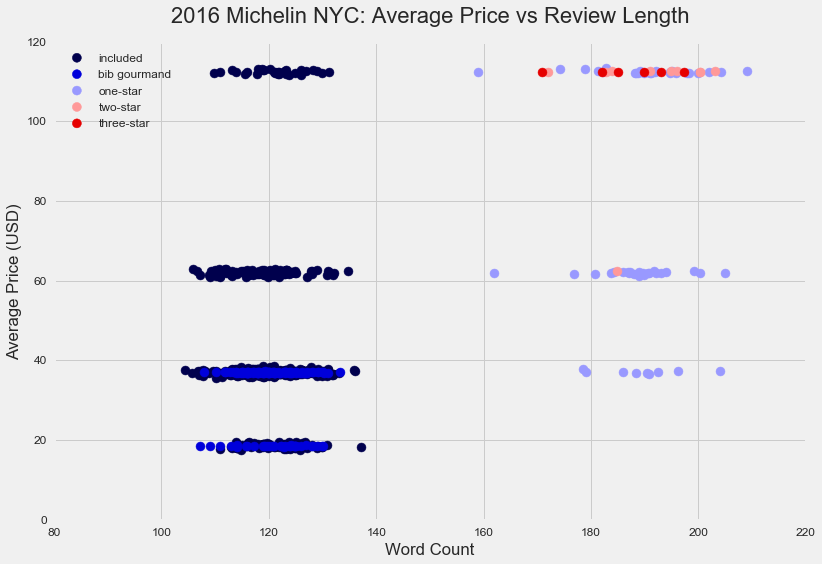

In [87]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(rand_jitter(df_incl['num_words']), rand_jitter(df_incl['avg_USD']), \
            color = distinction_colors[0], alpha = 1, s = 80, label = 'included')
plt.scatter(rand_jitter(df_bib['num_words']), rand_jitter(df_bib['avg_USD']), \
            color = distinction_colors[1], alpha = 1, s = 80, label = 'bib gourmand')
plt.scatter(rand_jitter(df_1['num_words']), rand_jitter(df_1['avg_USD']), \
            color = distinction_colors[2], alpha = 1, s = 80, label = 'one-star')
plt.scatter(rand_jitter(df_2['num_words']), rand_jitter(df_2['avg_USD']), \
            color = distinction_colors[3], alpha = 1, s = 80, label = 'two-star')
plt.scatter(rand_jitter(df_3['num_words']), rand_jitter(df_3['avg_USD']), \
            color = distinction_colors[4], alpha = 1, s = 80, label = 'three-star')

plt.title('2016 Michelin NYC: Average Price vs Review Length', fontsize = 22, y = 1.03)

# y label
plt.ylabel('Average Price (USD)')
plt.yticks(fontsize = 12)

# x label
plt.xlabel('Word Count')
plt.xticks(fontsize = 12)

# set the figure boundaries
# plt.ylim([-25, 400])
# plt.xlim([-25, 250])
plt.grid(True)
plt.legend(loc='upper left', fontsize = 12)

plt.show()

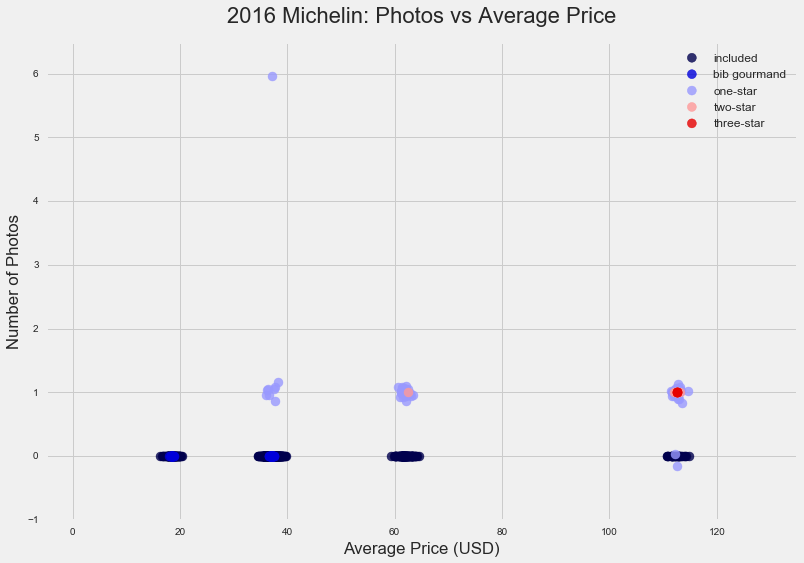

In [88]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.scatter(more_rand_jitter(df_incl['avg_USD']), more_rand_jitter(df_incl['photo_count']), \
            color = distinction_colors[0], alpha = 0.8, s = 80, label = 'included')
plt.scatter(more_rand_jitter(df_bib['avg_USD']), more_rand_jitter(df_bib['photo_count']), \
            color = distinction_colors[1], alpha = 0.8, s = 80, label = 'bib gourmand')
plt.scatter(more_rand_jitter(df_1['avg_USD']), more_rand_jitter(df_1['photo_count']), \
            color = distinction_colors[2], alpha = 0.8, s = 80, label = 'one-star')
plt.scatter(more_rand_jitter(df_2['avg_USD']), more_rand_jitter(df_2['photo_count']), \
            color = distinction_colors[3], alpha = 0.8, s = 80, label = 'two-star')
plt.scatter(more_rand_jitter(df_3['avg_USD']), more_rand_jitter(df_3['photo_count']), \
            color = distinction_colors[4], alpha = 0.8, s = 80, label = 'three-star')

plt.title('2016 Michelin: Photos vs Average Price', fontsize = 22, y = 1.03)

# y label
plt.ylabel('Number of Photos')

# x label
plt.xlabel('Average Price (USD)')

# set the figure boundaries
plt.ylim([-1, 6.5])
plt.xlim([-5, 135])
plt.grid(True)
plt.legend(loc='upper right', fontsize = 12)

plt.show()

In [89]:
df_1[df_1['photo_count'] == 0][['name', 'cuisine', 'avg_USD']]

,name,cuisine,avg_USD
483,Rosanjin,Japanese,112.5
682,Caviar Russe,Contemporary,112.5


In [90]:
standing_list = []
for i in range(len(df['adj_standing'].unique())):
    standing_list.append(df['adj_standing'].unique()[i])


standing_order = range(len(df['adj_standing'].unique()))

standing_dict = dict(zip(standing_list, standing_order))

ystand = pd.DataFrame(df['adj_standing'].value_counts())
y1stand = pd.DataFrame(df_1['adj_standing'].value_counts())
y2stand = pd.DataFrame(df_2['adj_standing'].value_counts())
y3stand = pd.DataFrame(df_3['adj_standing'].value_counts())
ybibstand = pd.DataFrame(df_bib['adj_standing'].value_counts())
y0stand = pd.DataFrame(df_incl['adj_standing'].value_counts())
big_ystand = pd.concat([ystand, y0stand, ybibstand, y1stand, y2stand, y3stand], axis = 1)
big_ystand.columns = ['all', 'included', 'bib gourmand', 'one star', 'two stars', \
                      'three stars']
big_ystand['adj_standing'] = big_ystand.index
big_ystand = big_ystand.reset_index(drop = True)
big_ystand = big_ystand[big_ystand['adj_standing'] != 0]
standing_order = range(len(df['adj_standing'].unique()))

big_ystand_dict = dict(zip(standing_list, standing_order))

big_ystand = big_ystand.set_index('adj_standing', drop = True)

big_ystand = big_ystand.fillna(0)
big_ystand

,all,included,bib gourmand,one star,two stars,three stars
adj_standing,,,,,,
12.0,340,245.0,88.0,7.0,0.0,0.0
12.5,17,12.0,1.0,4.0,0.0,0.0
13.0,415,340.0,44.0,27.0,4.0,0.0
13.5,25,17.0,0.0,5.0,1.0,2.0
14.0,42,31.0,0.0,10.0,1.0,0.0
14.5,9,2.0,0.0,4.0,3.0,0.0
15.0,3,1.0,0.0,1.0,0.0,1.0
15.5,4,1.0,0.0,1.0,0.0,2.0
16.5,2,0.0,0.0,0.0,1.0,1.0


/Users/Rebecca/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:968: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


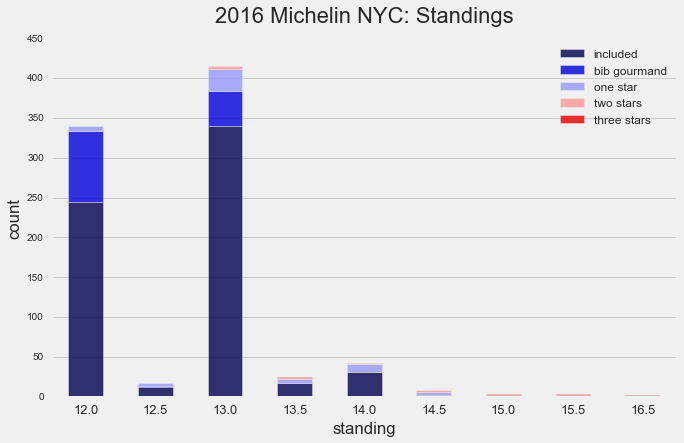

In [91]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

#big_ystand = big_ystand.sort('all', ascending = False)
big_ystand[['included', 'bib gourmand', 'one star', 'two stars', 'three stars']]\
    .plot(kind = 'bar', alpha = 0.8, stacked = True, colors = [distinction_colors[0],
                                                              distinction_colors[1],
                                                              distinction_colors[2],
                                                              distinction_colors[3],
                                                              distinction_colors[4]], \
                        figsize = (10, 6))

plt.title('2016 Michelin NYC: Standings', fontsize = 22, y = 1.03)

# y label
plt.ylabel('count')
#plt.ylim([0, 501])

# x label
plt.xlabel('standing')

# set the figure boundaries
# plt.ylim([40.6, 40.85])
# plt.xlim([-74.025, -73.925])
plt.grid(True)
plt.grid(which = 'major', axis = 'x')
plt.legend(loc='upper right', fontsize = 12)
plt.xticks(rotation = 0, fontsize = 13)

plt.show()

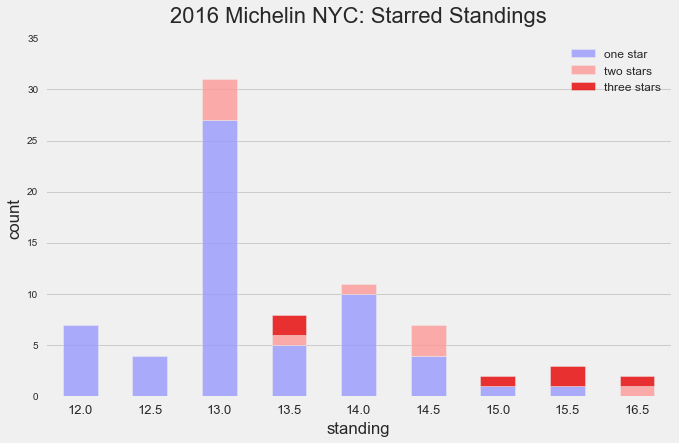

In [92]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

#big_ystand = big_ystand.sort('all', ascending = False)
big_ystand[['one star', 'two stars', 'three stars']].plot(kind = 'bar', alpha = 0.8, \
                            stacked = True, colors = [distinction_colors[2],
                                                      distinction_colors[3],
                                                      distinction_colors[4]],\
                            figsize = (10,6))

plt.title('2016 Michelin NYC: Starred Standings', fontsize = 22, y = 1.03)

# y label
plt.ylabel('count')

# x label
plt.xlabel('standing')

# set the figure boundaries
# plt.ylim([40.6, 40.85])
# plt.xlim([-74.025, -73.925])
plt.grid(True)
plt.grid(which = 'major', axis = 'x')
plt.legend(loc='upper right', fontsize = 12)
plt.xticks(rotation = 0, fontsize = 13)

plt.show()

In [93]:
cuisine_list = []
for i in range(len(df['cuisine'].unique())):
    cuisine_list.append(df['cuisine'].unique()[i])

order = range(len(df['cuisine'].unique()))

cuisine_dict = dict(zip(cuisine_list, order))

y = pd.DataFrame(df['cuisine'].value_counts())
y0 = pd.DataFrame(df_incl['cuisine'].value_counts())
ybib = pd.DataFrame(df_bib['cuisine'].value_counts())
y1 = pd.DataFrame(df_1['cuisine'].value_counts())
y2 = pd.DataFrame(df_2['cuisine'].value_counts())
y3 = pd.DataFrame(df_3['cuisine'].value_counts())


big_y = pd.concat([y, y0, ybib, y1, y2, y3], axis = 1)
big_y.columns = ['all', 'included', 'bib gourmand', 'one star', 'two stars', 'three stars']
big_y['cuisine'] = big_y.index
big_y = big_y.reset_index(drop = True)
order = range(len(df['cuisine'].unique()))

big_y_dict = dict(zip(cuisine_list, order))


big_y = big_y.set_index(big_y['cuisine'], drop = False)
del big_y['cuisine']

big_y = big_y.fillna(0)

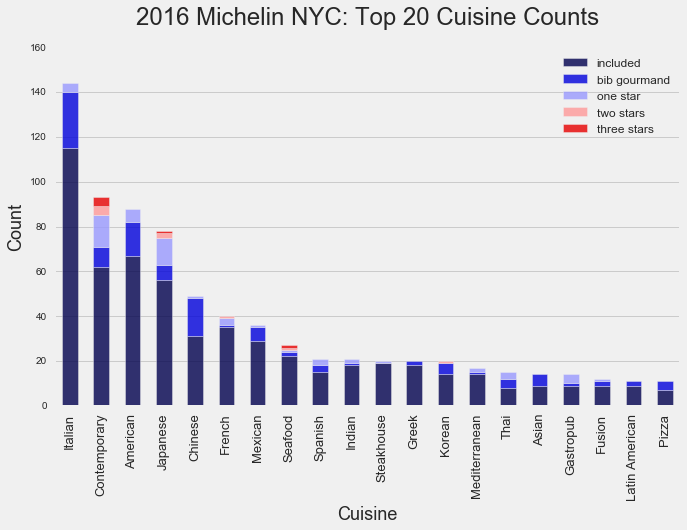

In [94]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

big_y = big_y.sort_values(by = 'all', ascending = False)
big_y[['included', \
       'bib gourmand', \
       'one star', \
       'two stars', \
       'three stars']][0:20].plot(kind = 'bar', alpha = 0.8, stacked = True, \
                            colors = distinction_colors, figsize = (10,6))

plt.title('2016 Michelin NYC: Top 20 Cuisine Counts', fontsize = 24, y = 1.05)

# y label
plt.ylabel('Count', fontsize = 18)

# x label
plt.xlabel('Cuisine', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.xticks(rotation = 90, fontsize = 9)

# plt.xlim([-1, len(cuisine_list)])
# plt.ylim([-1, 100])
plt.legend(loc='upper right', fontsize = 12)
plt.grid(which = 'major', axis = 'x')
plt.xticks(rotation = 90, fontsize = 13)
plt.show()

In [95]:
star_y = df[(df['stars'] == 1) | (df['stars'] == 2) | (df['stars'] == 3)]

star_cuisine = []
for i in range(len(star_y['cuisine'].unique())):
    star_cuisine.append(star_y['cuisine'].unique()[i])


star_order = range(len(star_y['cuisine'].unique()))

cuisine_dict = dict(zip(star_cuisine, star_order))

star_y = pd.DataFrame(star_y['cuisine'].value_counts())
star1 = pd.DataFrame(df_1['cuisine'].value_counts())
star2 = pd.DataFrame(df_2['cuisine'].value_counts())
star3 = pd.DataFrame(df_3['cuisine'].value_counts())
cuisine_stars = star1 + star2 + star3
big_star = pd.concat([star_y, star1, star2, star3], axis = 1)
big_star.columns = ['all_stars', 'one star', 'two stars', 'three stars']
big_star['cuisine'] = big_star.index
big_star = big_star.reset_index(drop = True)
order = range(len(star_y['cuisine'].unique()))

big_star_dict = dict(zip(star_cuisine, star_order))


big_star = big_star.set_index(big_star['cuisine'], drop = False)
del big_star['cuisine']

big_star = big_star.fillna(0)
len(big_star)

18

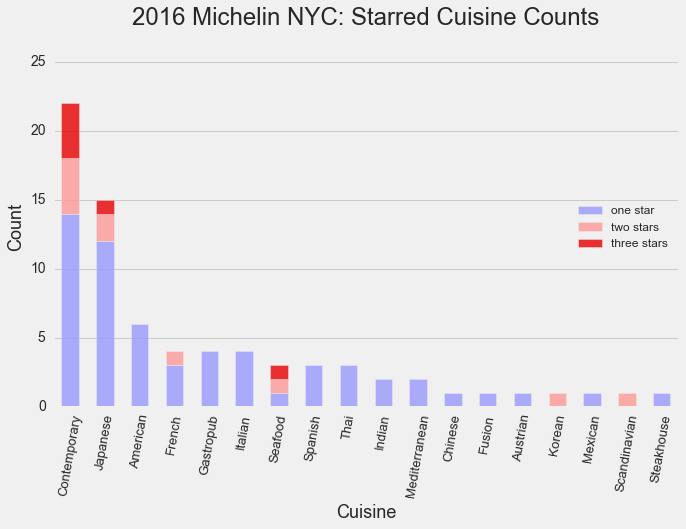

In [96]:
plt.style.use('fivethirtyeight')

big_star = big_star.sort_values(by = 'all_stars', ascending = False)
big_star[['one star', 'two stars', 'three stars']].plot(kind = 'bar', alpha = 0.8, \
                                    stacked = True, color = [distinction_colors[2], \
                                                             distinction_colors[3], \
                                                             distinction_colors[4]], \
                                    figsize = (10,6))

plt.title('2016 Michelin NYC: Starred Cuisine Counts', fontsize = 24, y = 1.05)

# y label
plt.ylabel('Count', fontsize = 18)

# x label
plt.xlabel('Cuisine', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)

# plt.xlim([-1, len(cuisine_list)])
plt.ylim([0, 26])
plt.legend(loc='center right', fontsize = 12)
plt.grid(which = 'major', axis = 'x')
plt.xticks(rotation = 80, fontsize = 13)
plt.yticks(rotation = 0, fontsize = 14)
plt.show()

In [97]:
len(df['ZIP'])

857

In [98]:
ZIP_list = []
for i in range(len(df['ZIP'].unique())):
    ZIP_list.append(df['ZIP'].unique()[i])

order = range(len(df['ZIP'].unique()))

ZIP_dict = dict(zip(cuisine_list, order))

y = pd.DataFrame(df['ZIP'].value_counts())
y0 = pd.DataFrame(df_incl['ZIP'].value_counts())
ybib = pd.DataFrame(df_bib['ZIP'].value_counts())
y1 = pd.DataFrame(df_1['ZIP'].value_counts())
y2 = pd.DataFrame(df_2['ZIP'].value_counts())
y3 = pd.DataFrame(df_3['ZIP'].value_counts())

big_y = pd.concat([y, y0, ybib, y1, y2, y3], axis = 1)
big_y.columns = ['all', 'included', 'bib gourmand', 'one star', 'two stars', 'three stars']
big_y['ZIP'] = big_y.index
big_y = big_y.reset_index(drop = True)
order = range(len(df['ZIP'].unique()))

big_y_dict = dict(zip(ZIP_list, order))


big_y = big_y.set_index(big_y['ZIP'], drop = False)
del big_y['ZIP']

big_y = big_y.fillna(0)

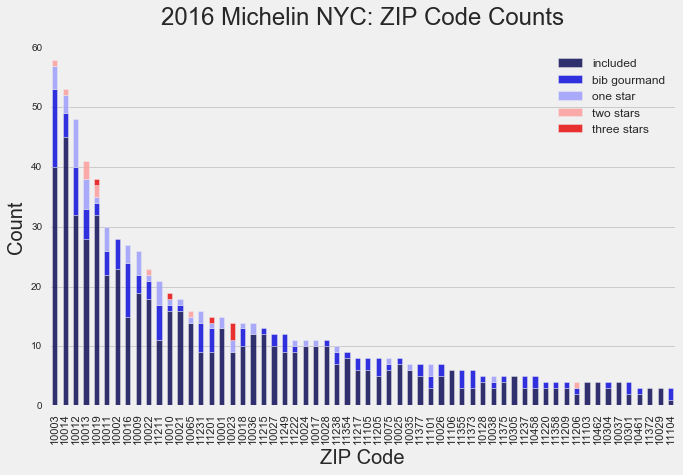

In [99]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

big_y = big_y.sort_values(by = 'all', ascending = False)
big_y[['included', \
       'bib gourmand', \
       'one star', \
       'two stars', \
       'three stars']][0:60].plot(kind = 'bar', alpha = 0.8, stacked = True, \
                            colors = distinction_colors, figsize = (10,6))

plt.title('2016 Michelin NYC: ZIP Code Counts', fontsize = 24, y = 1.05)

# y label
plt.ylabel('Count', fontsize = 20)

# x label
plt.xlabel('ZIP Code', fontsize = 20)
plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.xticks(rotation = 90, fontsize = 9)

# plt.xlim([-1, len(cuisine_list)])
# plt.ylim([-1, 100])
plt.legend(loc='upper right', fontsize = 12)
plt.grid(which = 'major', axis = 'x')
plt.xticks(rotation = 90, fontsize = 11)
plt.show()

In [100]:
star_y = df[(df['stars'] == 1) | (df['stars'] == 2) | (df['stars'] == 3)]

star_ZIP = []
for i in range(len(star_y['ZIP'].unique())):
    star_ZIP.append(star_y['ZIP'].unique()[i])


star_order = range(len(star_y['ZIP'].unique()))

ZIP_dict = dict(zip(star_ZIP, star_order))

star_y = pd.DataFrame(star_y['ZIP'].value_counts())
star1 = pd.DataFrame(df_1['ZIP'].value_counts())
star2 = pd.DataFrame(df_2['ZIP'].value_counts())
star3 = pd.DataFrame(df_3['ZIP'].value_counts())
ZIP_stars = star1 + star2 + star3
big_star = pd.concat([star_y, star1, star2, star3], axis = 1)
big_star.columns = ['all_stars', 'one star', 'two stars', 'three stars']
big_star['ZIP'] = big_star.index
big_star = big_star.reset_index(drop = True)
order = range(len(star_y['ZIP'].unique()))

big_star_dict = dict(zip(star_ZIP, star_order))


big_star = big_star.set_index(big_star['ZIP'], drop = False)
del big_star['ZIP']

big_star = big_star.fillna(0)

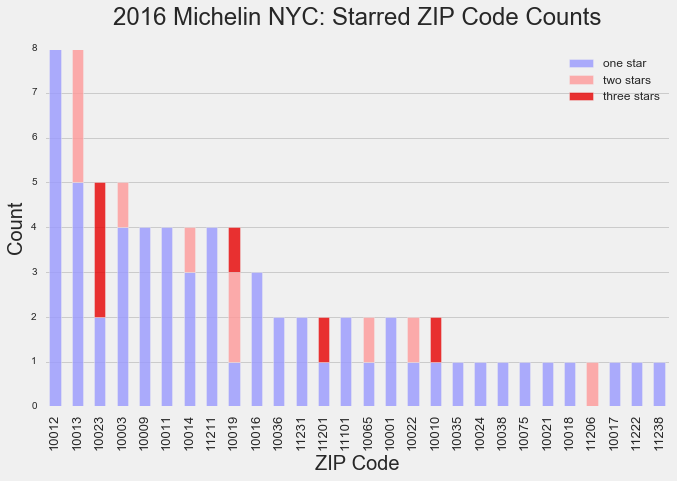

In [101]:
plt.style.use('fivethirtyeight')

big_star = big_star.sort_values(by = 'all_stars', ascending = False)
big_star[['one star', 'two stars', 'three stars']].plot(kind = 'bar', alpha = 0.8, \
                                    stacked = True, color = [distinction_colors[2], \
                                                             distinction_colors[3], \
                                                             distinction_colors[4]], \
                                    figsize = (10,6))

plt.title('2016 Michelin NYC: Starred ZIP Code Counts', fontsize = 24, y = 1.05)

# y label
plt.ylabel('Count', fontsize = 20)

# x label
plt.xlabel('ZIP Code', fontsize = 20)
plt.axhline(0, color='black', alpha = 0.6, linewidth = 1)
plt.xticks(rotation = 90, fontsize = 10)

# plt.xlim([-1, len(cuisine_list)])
# plt.ylim([-1, 100])
plt.legend(loc='upper right', fontsize = 12)
plt.grid(which = 'major', axis = 'x')
plt.xticks(rotation = 90, fontsize = 13)
plt.show()

In [102]:
cPickle.dump(df, open('df_postZIP.p', 'wb'))

Code below adapted from:
https://nicschrading.com/project/Intro-to-NLP-with-spaCy/

In [103]:
# parser = English()

# for j in range(len(df)):
#     multiSentence = df['blurb'][j]
#     parsedData = parser(unicode(multiSentence))

#     for i, token in enumerate(parsedData):
#         print"original:", token.orth, token.orth_
#         print"lowercased:", token.lower, token.lower_
#         print"lemma:", token.lemma, token.lemma_
#         print"shape:", token.shape, token.shape_
#         print"prefix:", token.prefix, token.prefix_
#         print"suffix:", token.suffix, token.suffix_
#         print"log probability:", token.prob
#         print"Brown cluster id:", token.cluster
#         print"----------------------------------------"
#         if i > 1:
#             break

#     # Let's look at the sentences
#     sents = []
#     # the "sents" property returns spans
#     # spans have indices into the original string
#     # where each index value represents a token
#     for span in parsedData.sents:
#         sent = ''.join(parsedData[i].string for i in range(span.start, span.end)).strip()
#         sents.append(sent)

#     for sentence in sents:
#         print sentence
#         print '-`-`-`-`-`-`-`-`-`-`-`-`-`-`-`-'

#     # Let's look at the part of speech tags of the first sentence
#     for span in parsedData.sents:
#         sent = [parsedData[i] for i in range(span.start, span.end)]
#         break

#     for token in sent:
#         print token.orth_, token.pos_

#     # Let's look at the dependencies of this example:
#     example = sents[0]
#     parsedEx = parser(unicode(example))
#     # shown as: original token, dependency tag, head word, left dependents, right dependents
#     for token in parsedEx:
#         print token.orth_, token.dep_, token.head.orth_, [t.orth_ for t in token.lefts], \
#               [t.orth_ for t in token.rights]
#         print '\n'

#     # Let's look at the named entities of this example:
#     example = sents[0]
#     parsedEx = parser(unicode(example))
#     for token in parsedEx:
#         print token.orth_, token.ent_type_ if token.ent_type_ != "" else "(not an entity)"

#     print("-------------- entities only ---------------")
#     # if you just want the entities and nothing else, you can do access the parsed examples \
#     # "ents" property like this:
#     ents = list(parsedEx.ents)
#     for entity in ents:
#         print entity.label, entity.label_, ' '.join(t.orth_ for t in entity)

#     messyData = sents[0]
#     parsedData = parser(unicode(messyData))
#     for token in parsedData:
#         print token.orth_, token.pos_, token.lemma_

In [104]:
# blurbs = df['blurb']

In [105]:
# import string
# import nltk
# from nltk import PorterStemmer
# from nltk.corpus import stopwords

# def nice_n_clean(blurb):
#     nopunct = ''.join([w for w in blurb if w not in string.punctuation])
#     normalized = [w for w in nopunct if w.lower() not in stopwords.words('english')]
#     tokens = nltk.word_tokenize(normalized)
#     stemmer = nltk.PorterStemmer()
#     stems = stem_tokens(tokens, stemmer)
#     return tokens, stems

# def new_parts(column):
#     tokens = []
#     stems = []
#     for i in range(len(column)):
        

# fd = nltk.FreqDist(data)
# fd.plot()
# fd.plot(50, cumulative=True)
# fd.most_common(12)
# ' '.join(normalized[0:100])

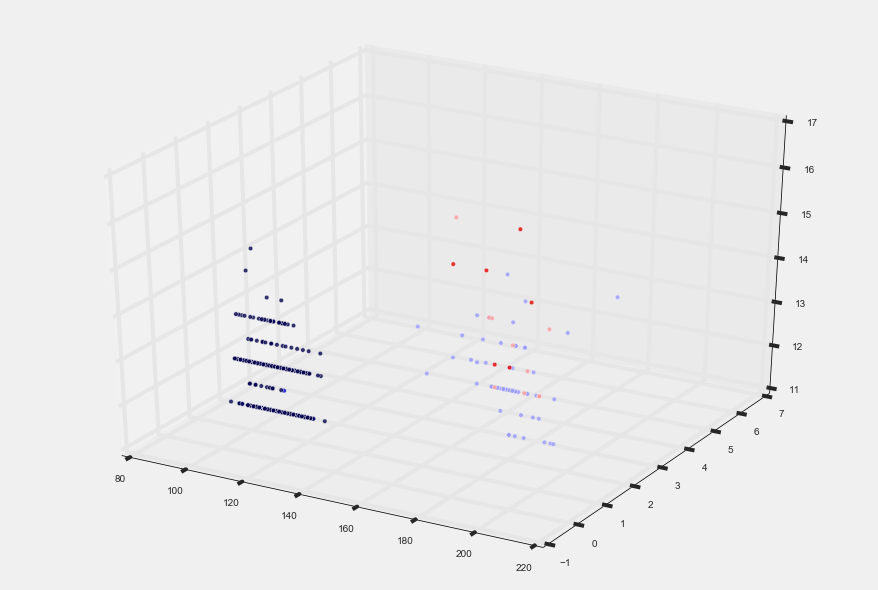

In [106]:
import pylab
from mpl_toolkits.mplot3d import Axes3D

fig = pylab.figure(figsize = (12,8))
ax = Axes3D(fig)
ax.scatter(df_3['num_words'], df_3['photo_count'], df_3['adj_standing'], zdir='z', \
           c=distinction_colors[4], alpha=.8)
ax.scatter(df_2['num_words'], df_2['photo_count'], df_2['adj_standing'], zdir='z', \
           c=distinction_colors[3], alpha=.8)
ax.scatter(df_1['num_words'], df_1['photo_count'], df_1['adj_standing'], zdir='z', \
           c=distinction_colors[2], alpha=.8)
ax.scatter(df_incl['num_words'], df_incl['photo_count'], df_incl['adj_standing'], zdir='z', \
           c=distinction_colors[0], alpha=.8)
ax.scatter(df_bib['num_words'], df_bib['photo_count'], df_bib['adj_standing'], zdir='z', \
           c=distinction_colors[1], alpha=.8)
plt.show()

In [107]:
## not included :
## 'num_words', 'photo_count', 'standing', 'bib', 'included', [.....others.....]
X = df[['latitude', 'longitude', 'name_len', 'avg_USD', 'wine', 'outside_dining', 'parking', \
        'wheelchair', 'private_dining', 'valet', 'cuisine', 'ZIP', 'osm_type']]

X = pd.concat([X.drop(['cuisine'], axis = 1), \
                             pd.get_dummies(X['cuisine'])], axis = 1)
X = pd.concat([X.drop(['ZIP'], axis = 1), \
                             pd.get_dummies(X['ZIP'])], axis = 1)
X = pd.concat([X.drop(['osm_type'], axis = 1), \
                             pd.get_dummies(X['osm_type'])], axis = 1)

y = df['stars']

In [108]:
X_scaled = MinMaxScaler().fit_transform(X.astype(float))
X_scaled = pd.DataFrame(X_scaled, columns = X.columns)

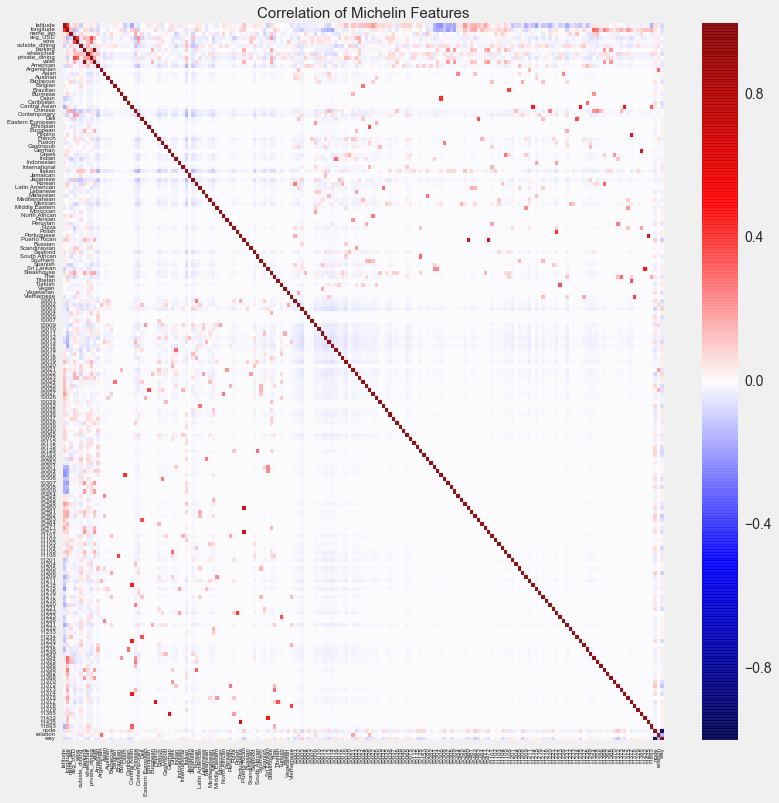

In [109]:
plt.figure(figsize=(12,12))
sns.set(font_scale=1.4)
ax = sns.heatmap(X_scaled.corr(), cmap = "seismic", alpha = 0.9)

ax.axes.set_title("Correlation of Michelin Features", size = 15)

plt.xticks(fontsize = 6)
plt.yticks(fontsize = 6)

plt.show()

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.25, \
                                                    random_state = 45)

print "       X Shape  Y Shape"
print "Train", X_train.shape, y_train.shape
print "Test ", X_test.shape, y_test.shape

       X Shape  Y Shape
Train (642, 177) (642,)
Test  (215, 177) (215,)


In [98]:
n = 50
plot_colors = []
for i in range(0, 256, 256/50):
    plot_colors.append(cm.plasma(i))

cv = KFold(len(X_train), n_folds = n, shuffle=False)

def do_plot(model, m=1):
    
    for fold, color in zip(cv, plot_colors):
        X_train = X_scaled.iloc[fold[0]]
        X_test  = X_scaled.iloc[fold[1]]
        y_train = y.iloc[fold[0]]
        y_test  = y.iloc[fold[1]]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        plt.plot([-0.01, 3.25],[-0.01, 3.25], linewidth = 0.1)
        plt.text(2.5, 3, "R^2: "+str(m), fontsize=16)
        
        plt.scatter(more_rand_jitter(y_pred), more_rand_jitter(y_test), color=color, s = 80)
        
    return

In [86]:
def plot_confusion_matrix(cmat, title='Confusion matrix', cmap=plt.cm.Blues, \
                          labels = ['0', '1', '2', '3']):
    
    plt.figure(figsize=(12,8))
    plt.imshow(cmat, interpolation='nearest', cmap=cmap)
    
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, fontsize = 14)
    plt.yticks(tick_marks, labels, fontsize = 14)
        
    plt.title(title)
    plt.ylabel('True Number of Stars')
    plt.xlabel('Predicted Number of Stars')
    plt.tight_layout()
    
    width, height = cmat.shape
    
    for x in xrange(width):
        for y in xrange(height):
            plt.annotate(str(cmat[x][y]), xy=(y, x), 
                        horizontalalignment='center',
                        verticalalignment='center',
                        color = 'white',
                        fontsize=18).set_path_effects([path_effects.Stroke(linewidth=1, 
                        foreground='black'), path_effects.Normal()]) 
    return

def getROCcurve(roc, title='ROC Curve', xlabel ='% of False Positives', \
                ylabel = '% of True Positives'):
    fpr, tpr, thresholds = roc
    
    fig,ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC Curve')

    fig.set_size_inches(7, 6, forward=True)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend(loc='best')
    plt.plot([0, 1], [0, 1], 'k--', linewidth = 0.4, color = 'magenta')
    return

code below adapted from:
http://scikit-learn.org/stable/auto_examples/model_selection/randomized_search.html

In [87]:
def report(grid_scores, n_top=3):
    '''Reports best scores of gridsearches completed.'''
    top_scores = sorted(grid_scores, key=itemgetter(1), reverse=True)[:n_top]
    for i, score in enumerate(top_scores):
        print("Model with rank: {0}".format(i + 1))
        print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
              score.mean_validation_score,
              np.std(score.cv_validation_scores)))
        print("Parameters: {0}".format(score.parameters))
        print("")

param_grid = {"max_depth": [3, None],
              "max_features": [10, 20],
              "min_samples_split": [1, 3],
              "min_samples_leaf": [1, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}

### Decision Tree Classifier

In [88]:
dt = DecisionTreeClassifier()

scores = cross_val_score(dt, X_train, y_train, cv=cv)
scores.mean()

0.88666666666666683

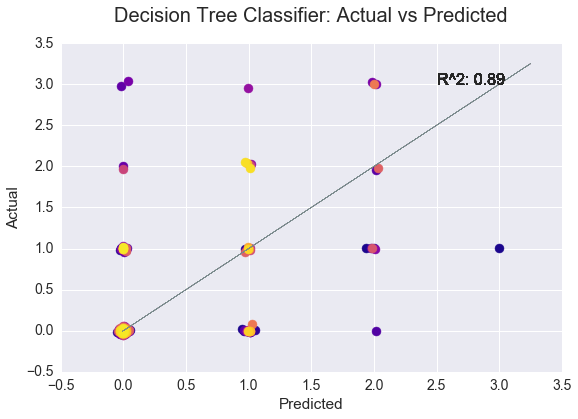

In [89]:
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Decision Tree Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')

# can't get this to work, "PathCollection object not iterable" error
# ax.set_yticks([0, 1, 2, 3], minor=False)
# ax.set_yticks([0, 1, 2, 3], minor=True)
# ax.yaxis.grid(True, which='major')
# ax.yaxis.grid(True, which='minor')


do_plot(dt, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


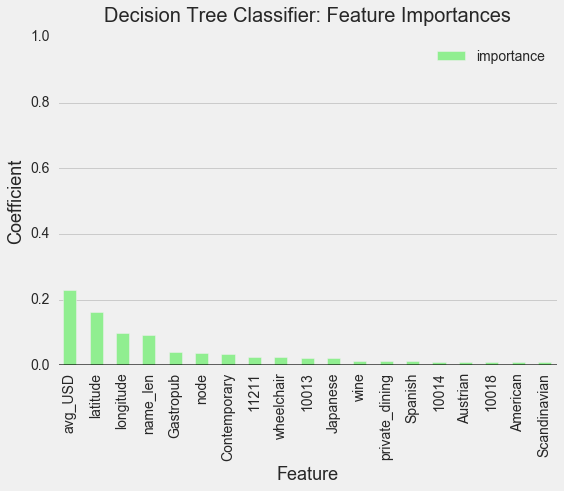

In [327]:
dt.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), dt.feature_importances_), X_scaled.columns), \
                  reverse=True)
features_dt = pd.DataFrame(features, columns = ['importance', 'feature'])
features_dt = features_dt.sort('importance', ascending = False)
features_dt = features_dt.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_dt[0:19].plot.bar(color = 'lightgreen')

plt.title('Decision Tree Classifier: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 14)

plt.grid(which = 'major', axis = 'x')

plt.ylim([0, 1])
plt.show()

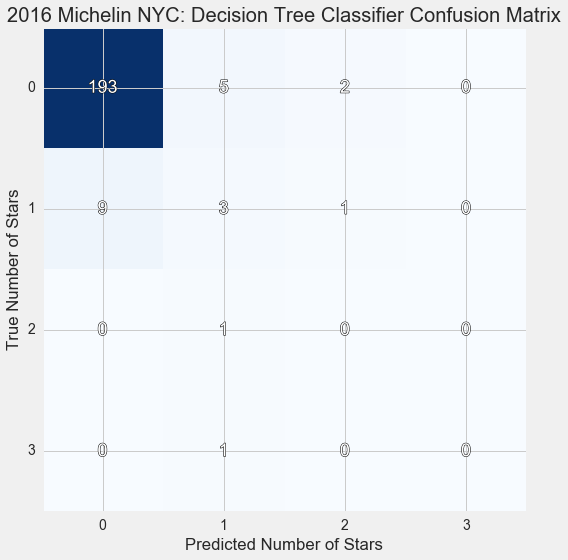

In [328]:
y_pred = dt.fit(X_train, y_train).predict(X_test)

#pred1 = dt.predict_proba(X_train).T[1]

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                      '2016 Michelin NYC: Decision Tree Classifier Confusion Matrix')

In [329]:
float(len(df) - (len(df_incl) + len(df_bib)))/len(df) # null error rate

0.08751458576429405

In [330]:
float(len(df_incl) + len(df_bib))/len(df)

0.912485414235706

In [331]:
print 'Decision Tree Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Decision Tree Classifier:
accuracy: 0.911627906977
precision: 0.906926087958
recall: 0.911627906977


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [332]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       200
          1       0.30      0.23      0.26        13
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         1

avg / total       0.91      0.91      0.91       215



In [266]:
# run grid search
gsdt = GridSearchCV(dt, param_grid = {"max_depth": [3, None],
              "max_features": [10, 20],
              "min_samples_split": [1, 3],
              "min_samples_leaf": [1, 3],
#              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]})
start = time.time()
gsdt.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(gsdt.grid_scores_)))
print '\n'
report(gsdt.grid_scores_)

GridSearchCV took 0.46 seconds for 32 candidate parameter settings.


Model with rank: 1
Mean validation score: 0.908 (std: 0.002)
Parameters: {'max_features': 10, 'min_samples_split': 1, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 2
Mean validation score: 0.908 (std: 0.005)
Parameters: {'max_features': 20, 'min_samples_split': 3, 'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 3}

Model with rank: 3
Mean validation score: 0.907 (std: 0.003)
Parameters: {'max_features': 10, 'min_samples_split': 1, 'criterion': 'gini', 'max_depth': None, 'min_samples_leaf': 3}



In [267]:
gsdt.best_params_

{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 3,
 'min_samples_split': 1}

In [268]:
scores = cross_val_score(gsdt, X_train, y_train, cv=cv)
scores.mean()

0.90076923076923077

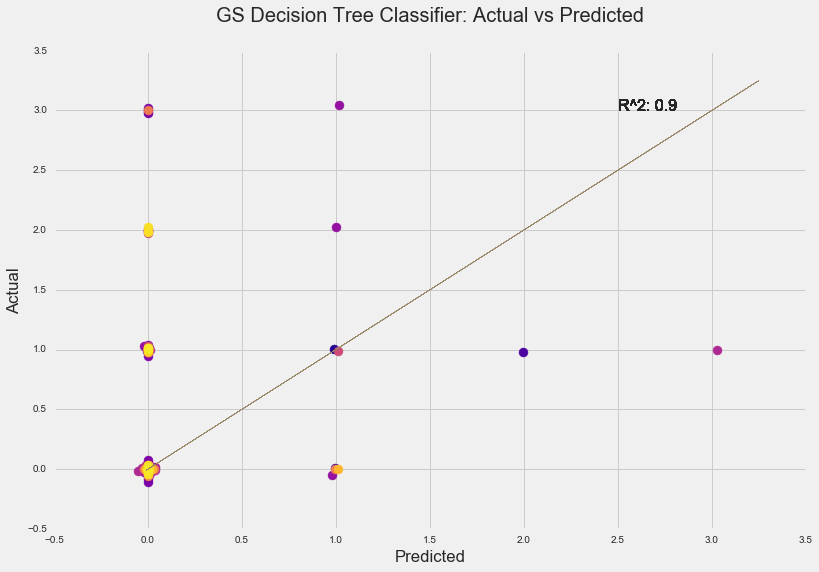

In [269]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GS Decision Tree Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(gsdt, scores.mean().round(2))

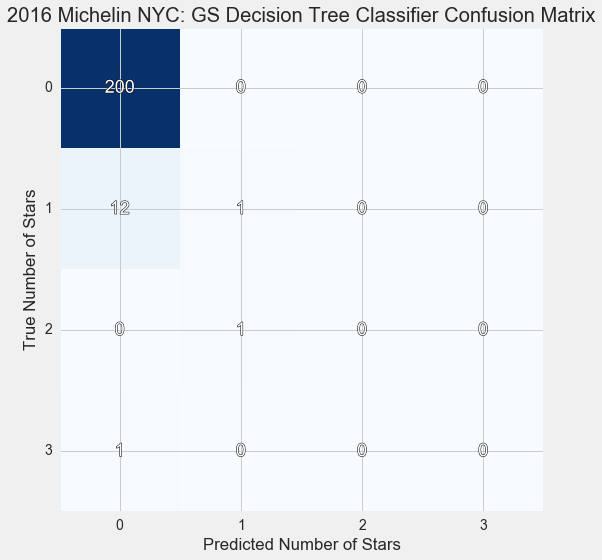

In [270]:
y_pred = gsdt.fit(X_train, y_train).predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                      '2016 Michelin NYC: GS Decision Tree Classifier Confusion Matrix')

In [271]:
print 'Extra Trees Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Extra Trees Classifier:
accuracy: 0.93488372093
precision: 0.90369035921
recall: 0.93488372093


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [272]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.94      1.00      0.97       200
          1       0.50      0.08      0.13        13
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         1

avg / total       0.90      0.93      0.91       215



### Extra Trees Classifier

In [273]:
et = ExtraTreesClassifier()

scores = cross_val_score(et, X_train, y_train, cv=cv)
scores.mean()

0.90051282051282056

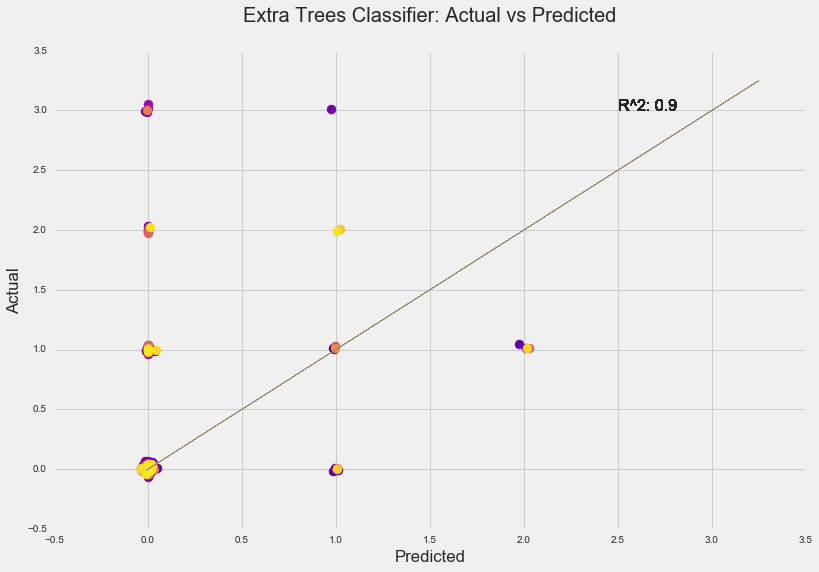

In [274]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Extra Trees Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(et, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


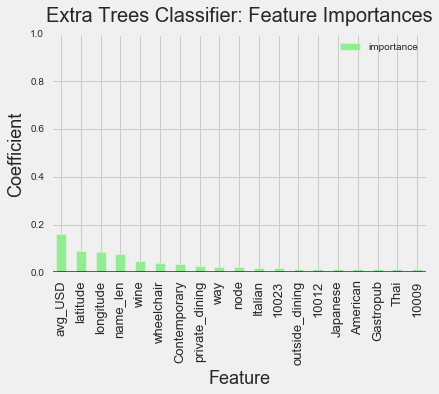

In [275]:
et.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), et.feature_importances_), X_scaled.columns), \
                  reverse=True)
features_et = pd.DataFrame(features, columns = ['importance', 'feature'])
features_et = features_et.sort('importance', ascending = False)
features_et = features_et.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_et[0:19].plot.bar(color = 'lightgreen')

plt.title('Extra Trees Classifier: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.ylim([0, 1])
plt.show()

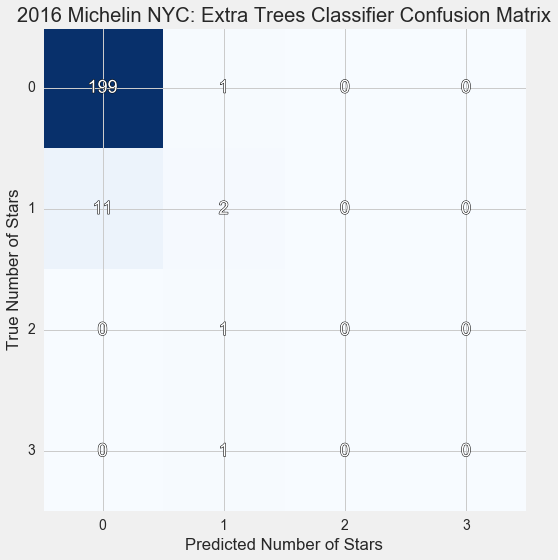

In [276]:
y_pred = et.fit(X_train, y_train).predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                      '2016 Michelin NYC: Extra Trees Classifier Confusion Matrix')

In [277]:
print 'Extra Trees Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Extra Trees Classifier:
accuracy: 0.93488372093
precision: 0.90569213732
recall: 0.93488372093


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [278]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.95      0.99      0.97       200
          1       0.40      0.15      0.22        13
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         1

avg / total       0.91      0.93      0.92       215



In [279]:
gset.get_params().keys()

['n_jobs',
 'verbose',
 'estimator__max_features',
 'estimator__max_depth',
 'param_grid',
 'cv',
 'scoring',
 'estimator__criterion',
 'estimator__max_leaf_nodes',
 'estimator__verbose',
 'estimator__n_jobs',
 'estimator__min_samples_leaf',
 'estimator__oob_score',
 'fit_params',
 'estimator__min_samples_split',
 'estimator__warm_start',
 'refit',
 'iid',
 'estimator__bootstrap',
 'estimator__min_weight_fraction_leaf',
 'estimator__n_estimators',
 'pre_dispatch',
 'estimator__class_weight',
 'estimator__random_state',
 'estimator',
 'error_score']

In [280]:
# run grid search
gset = GridSearchCV(et, param_grid=param_grid)
start = time.time()
gset.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(gset.grid_scores_)))
print '\n'
report(gset.grid_scores_)

GridSearchCV took 5.21 seconds for 64 candidate parameter settings.


Model with rank: 1
Mean validation score: 0.907 (std: 0.003)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 10, 'max_depth': 3}

Model with rank: 2
Mean validation score: 0.907 (std: 0.003)
Parameters: {'bootstrap': True, 'min_samples_leaf': 1, 'min_samples_split': 3, 'criterion': 'gini', 'max_features': 10, 'max_depth': 3}

Model with rank: 3
Mean validation score: 0.907 (std: 0.003)
Parameters: {'bootstrap': True, 'min_samples_leaf': 3, 'min_samples_split': 1, 'criterion': 'gini', 'max_features': 10, 'max_depth': 3}



In [281]:
gset.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 1}

In [ ]:
scores = cross_val_score(gset, X_train, y_train, cv=cv)
scores.mean()

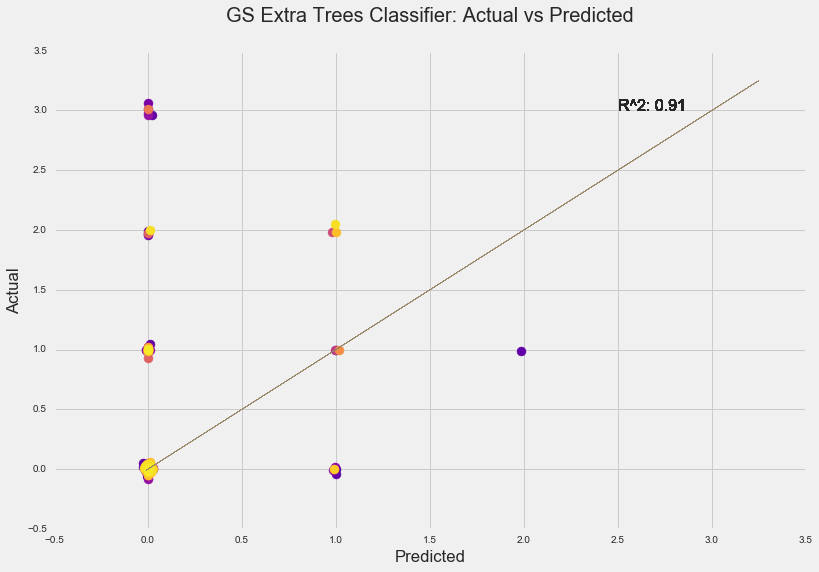

In [238]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GS Extra Trees Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(gset, scores.mean().round(2))

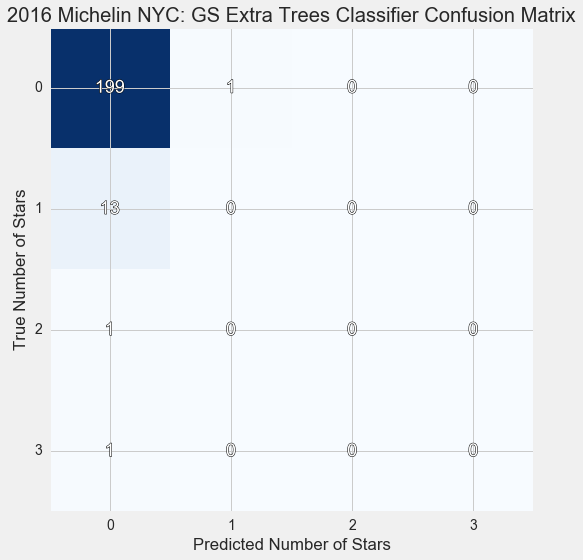

In [239]:
y_pred = gset.fit(X_train, y_train).predict(X_test)

#pred1 = gset.predict_proba(X_train).T[1]

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                      '2016 Michelin NYC: GS Extra Trees Classifier Confusion Matrix')

In [241]:
print 'GS Extra Trees Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

GS Extra Trees Classifier:
accuracy: 0.925581395349
precision: 0.865029341448
recall: 0.925581395349


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [240]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.93      0.99      0.96       200
          1       0.00      0.00      0.00        13
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         1

avg / total       0.87      0.93      0.89       215



### Gradient Boosting Classifier

In [242]:
gb = GradientBoostingClassifier()

scores = cross_val_score(gb, X_train, y_train, cv=cv)
scores.mean()

0.90525641025641024

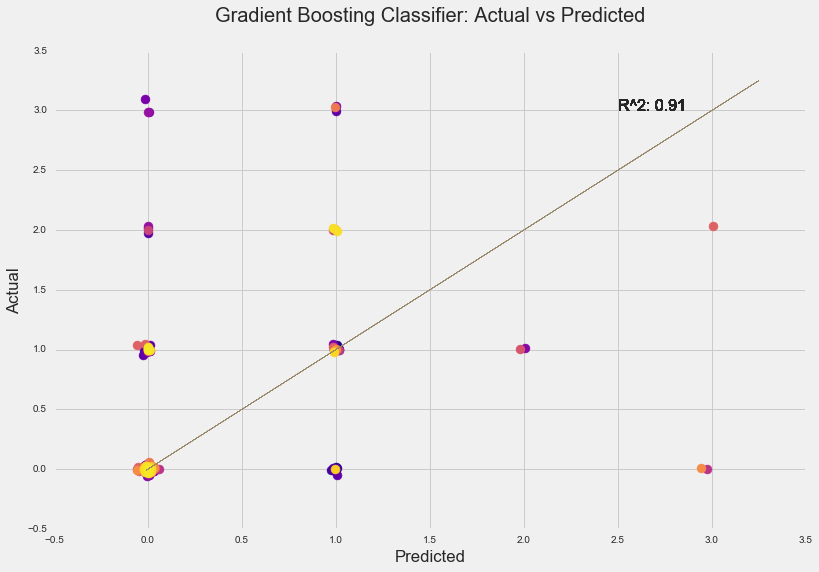

In [243]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Gradient Boosting Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(gb, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


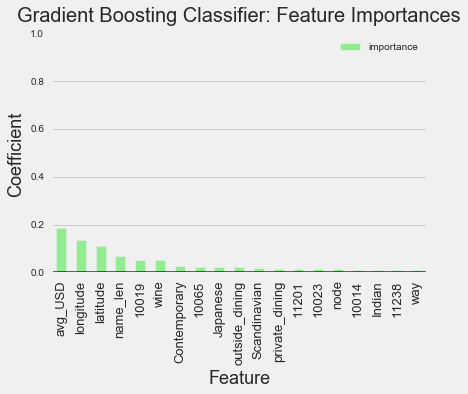

In [244]:
gb.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), gb.feature_importances_), X_scaled.columns), \
                  reverse=True)
features_gb = pd.DataFrame(features, columns = ['importance', 'feature'])
features_gb = features_gb.sort('importance', ascending = False)
features_gb = features_gb.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_gb[0:19].plot.bar(color = 'lightgreen')

plt.title('Gradient Boosting Classifier: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.ylim([0, 1])
plt.show()

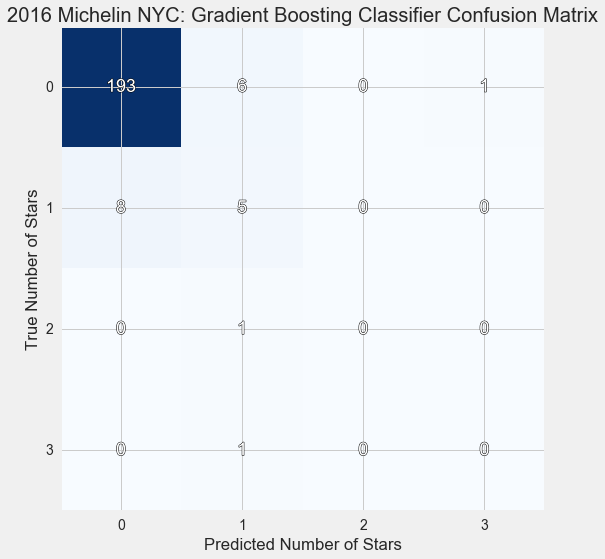

In [245]:
y_pred = gb.fit(X_train, y_train).predict(X_test)

pred1 = gb.predict_proba(X_train).T[1]

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                    '2016 Michelin NYC: Gradient Boosting Classifier Confusion Matrix')

In [246]:
print 'Gradient Boosting Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Gradient Boosting Classifier:
accuracy: 0.920930232558
precision: 0.916464190675
recall: 0.920930232558


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [247]:
print classification_report(y_test, y_pred)

             precision    recall  f1-score   support

          0       0.96      0.96      0.96       200
          1       0.38      0.38      0.38        13
          2       0.00      0.00      0.00         1
          3       0.00      0.00      0.00         1

avg / total       0.92      0.92      0.92       215



In [249]:
gsgb.get_params().keys()

['n_jobs',
 'verbose',
 'estimator__max_features',
 'estimator__max_depth',
 'param_grid',
 'cv',
 'scoring',
 'estimator__max_leaf_nodes',
 'estimator__init',
 'estimator__verbose',
 'pre_dispatch',
 'estimator__loss',
 'estimator__min_samples_leaf',
 'fit_params',
 'estimator__min_samples_split',
 'estimator__warm_start',
 'refit',
 'iid',
 'estimator__min_weight_fraction_leaf',
 'estimator__n_estimators',
 'estimator__presort',
 'estimator__learning_rate',
 'estimator__random_state',
 'estimator',
 'error_score',
 'estimator__subsample']

In [254]:
# run grid search
gsgb = GridSearchCV(gb, param_grid = {"max_depth": [3, None],
              "max_features": [10, 20],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
#              "bootstrap": [True, False],
#              "criterion": ["gini", "entropy"]\
                                     })
start = time.time()
gsgb.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(gsgb.grid_scores_)))
print '\n'
report(gsgb.grid_scores_)

GridSearchCV took 43.42 seconds for 36 candidate parameter settings.


Model with rank: 1
Mean validation score: 0.908 (std: 0.006)
Parameters: {'max_features': 10, 'min_samples_split': 3, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 2
Mean validation score: 0.907 (std: 0.003)
Parameters: {'max_features': 10, 'min_samples_split': 1, 'max_depth': 3, 'min_samples_leaf': 10}

Model with rank: 3
Mean validation score: 0.907 (std: 0.010)
Parameters: {'max_features': 10, 'min_samples_split': 3, 'max_depth': None, 'min_samples_leaf': 10}



In [284]:
gsgb.best_params_

{'max_depth': 3,
 'max_features': 10,
 'min_samples_leaf': 10,
 'min_samples_split': 3}

In [99]:
scores = cross_val_score(gsgb, X_train, y_train, cv=cv)
scores.mean()

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GS Gradient Boosting Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(gsgb, scores.mean().round(2))

In [ ]:
y_pred = gsgb.fit(X_train, y_train).predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                      '2016 Michelin NYC: GS Gradient Boosting Classifier Confusion Matrix')

In [ ]:
print 'GS Gradient Boosting Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

In [ ]:
print classification_report(y_test, y_pred)

### ADA Booster

In [105]:
ab = AdaBoostClassifier()

scores = cross_val_score(ab, X_train, y_train, cv=cv)
scores.mean()

0.86474358974358967

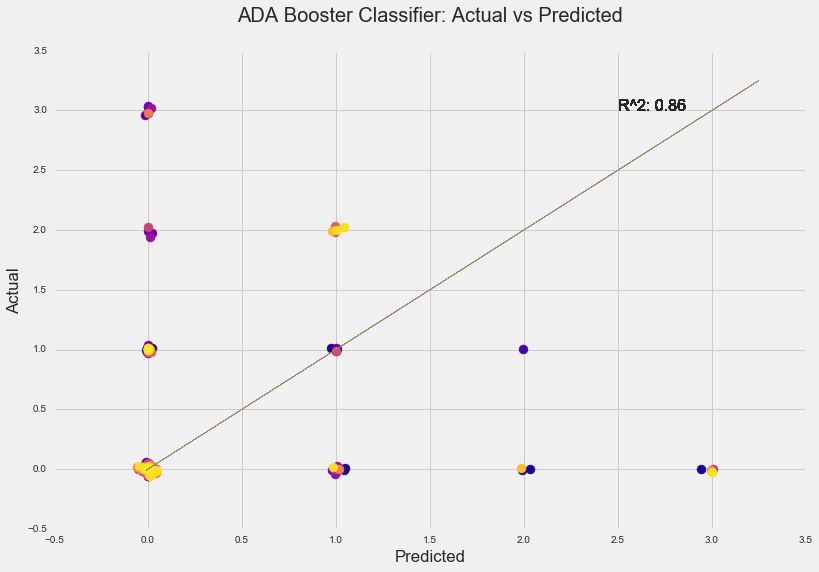

In [106]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('ADA Booster Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(ab, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


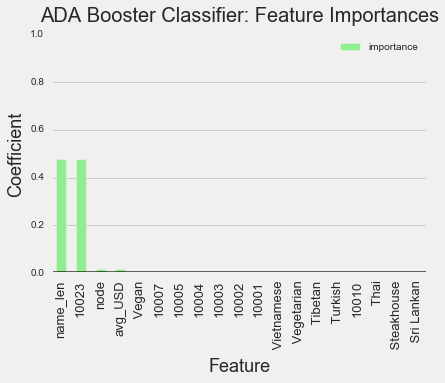

In [107]:
ab.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), ab.feature_importances_), X_scaled.columns), \
                  reverse=True)
features_ab = pd.DataFrame(features, columns = ['importance', 'feature'])
features_ab = features_ab.sort('importance', ascending = False)
features_ab = features_ab.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_ab[0:19].plot.bar(color = 'lightgreen')

plt.title('ADA Booster Classifier: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 18)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.ylim([0, 1])
plt.show()

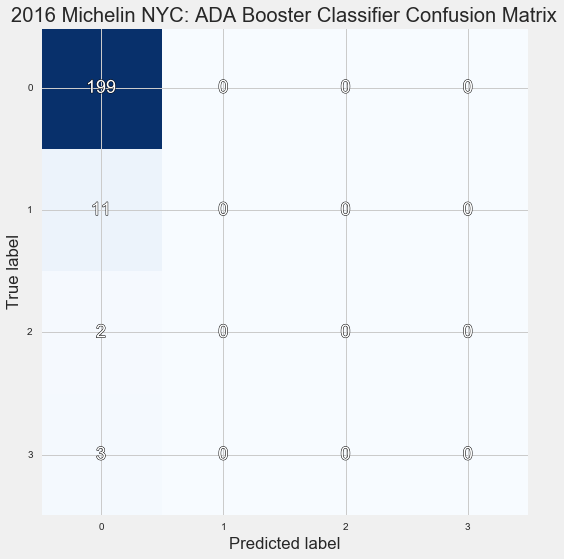

In [108]:
y_pred = ab.fit(X_train, y_train).predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                    '2016 Michelin NYC: ADA Booster Classifier Confusion Matrix')

In [109]:
print 'ADA Booster Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

ADA Booster Classifier:
accuracy: 0.925581395349
precision: 0.856700919416
recall: 0.925581395349


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [ ]:
print classification_report(y_test, y_pred)

In [ ]:
# run grid search
gsab = GridSearchCV(ab, param_grid = {"max_depth": [3, None],
              "max_features": [10, 20],
              "min_samples_split": [1, 3],
              "min_samples_leaf": [1, 3],
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]})
start = time.time()
gsab.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time.time() - start, len(gsab.grid_scores_)))
print '\n'
report(gsab.grid_scores_)

In [ ]:
gsab.best_params_

In [ ]:
scores = cross_val_score(gsab, X_train, y_train, cv=cv)
scores.mean()

In [ ]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('GS ADA Boost Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(gsab, scores.mean().round(2))

In [ ]:
y_pred = gsab.fit(X_train, y_train).predict(X_test)

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                    '2016 Michelin NYC: GS ADA Booster Classifier Confusion Matrix')

In [ ]:
print 'GS ADA Boosting Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

In [ ]:
print classification_report(y_test, y_pred)

### Random Forest Classification

In [110]:
rf = RandomForestClassifier()

scores = cross_val_score(rf, X_train, y_train, cv=cv)
scores.mean()

0.90487179487179492

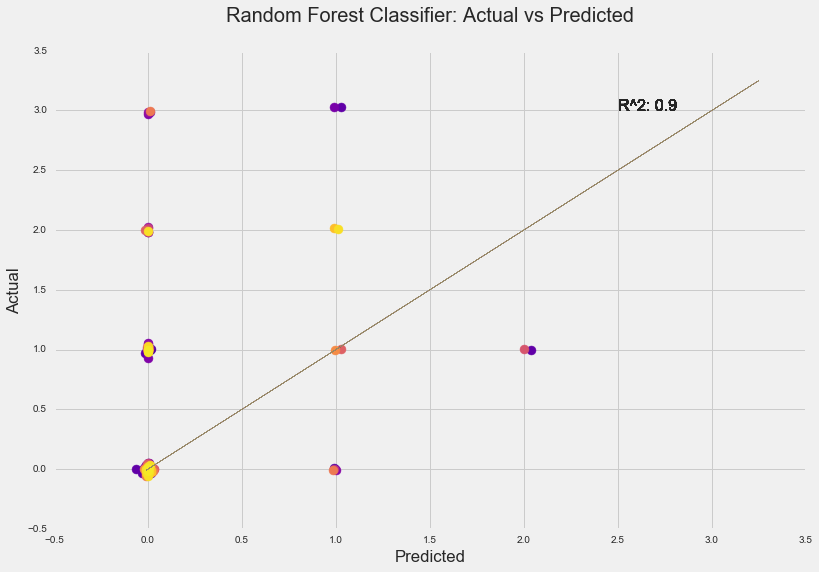

In [111]:
plt.figure(figsize=(12,8))
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Random Forest Classifier: Actual vs Predicted', fontsize = 20, y = 1.05)
plt.style.use('fivethirtyeight')


do_plot(rf, scores.mean().round(2))

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


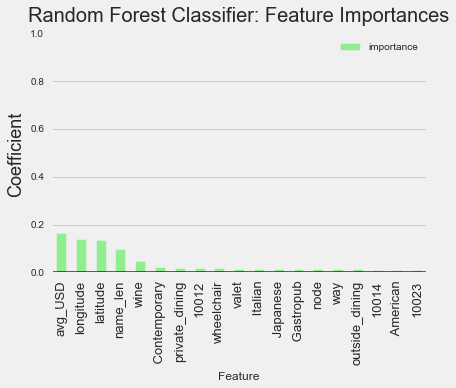

In [112]:
rf.fit(X_scaled, y)
features = sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), X_scaled.columns), \
                  reverse=True)
features_rf = pd.DataFrame(features, columns = ['importance', 'feature'])
features_rf = features_rf.sort('importance', ascending = False)
features_rf = features_rf.set_index('feature', drop = True)

plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

features_rf[0:19].plot.bar(color = 'lightgreen')

plt.title('Random Forest Classifier: Feature Importances', fontsize = 20, y = 1.03)

# y label
plt.ylabel('Coefficient', fontsize = 18)

# x label
plt.xlabel('Feature', fontsize = 12)
plt.axhline(0, color='black', alpha = 0.6)
plt.xticks(rotation = 90, fontsize = 13)

plt.grid(which = 'major', axis = 'x')

plt.ylim([0, 1])
plt.show()

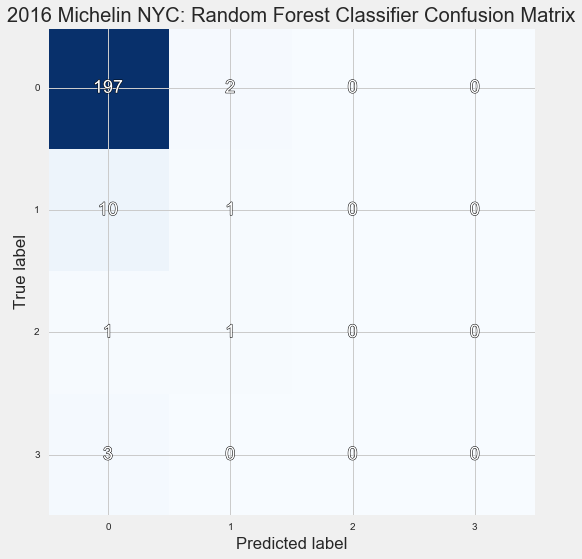

In [113]:
y_pred = rf.fit(X_train, y_train).predict(X_test)

pred1 = rf.predict_proba(X_train).T[1]

cmat = confusion_matrix(y_test, y_pred)

plot_confusion_matrix(cmat, title = \
                    '2016 Michelin NYC: Random Forest Classifier Confusion Matrix')

In [114]:
print 'Random Forest Classifier:'
print 'accuracy: %s' %accuracy_score(y_test, y_pred) # (TP + TN) / (P + N)
print 'precision: %s' %precision_score(y_test, y_pred) # TP / P
print 'recall: %s' %recall_score(y_test, y_pred) # TP / (TP + FN)

Random Forest Classifier:
accuracy: 0.920930232558
precision: 0.876959109446
recall: 0.920930232558


/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1203: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="f1".
  sample_weight=sample_weight)
/Users/Rebecca/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1304: DeprecationWarning: The default `weighted` averaging is deprecated, and from version 0.18, use of precision, recall or F-score with multiclass or multilabel data or pos_label=None will result in an exception. Please set an explicit value for `average`, one of (None, 'micro', 'macro', 'weighted', 'samples'). In cross validation use, for instance, scoring="f1_weighted" instead of scoring="

In [293]:
def TheAccumulator(df):
    cumulative = []
    total = 0
    for i in range(len(df)):
        cumulative.append(total)
        total += df['importance'][i]
    df['sum'] = cumulative
    df = df.reset_index(drop = True)
    return df

features_gsdt = TheAccumulator(features_dt)
features_gset = TheAccumulator(features_et)
features_gsgb = TheAccumulator(features_gb)
#features_ab = TheAccumulator(features_ab)
#features_rf = TheAccumulator(features_rf)

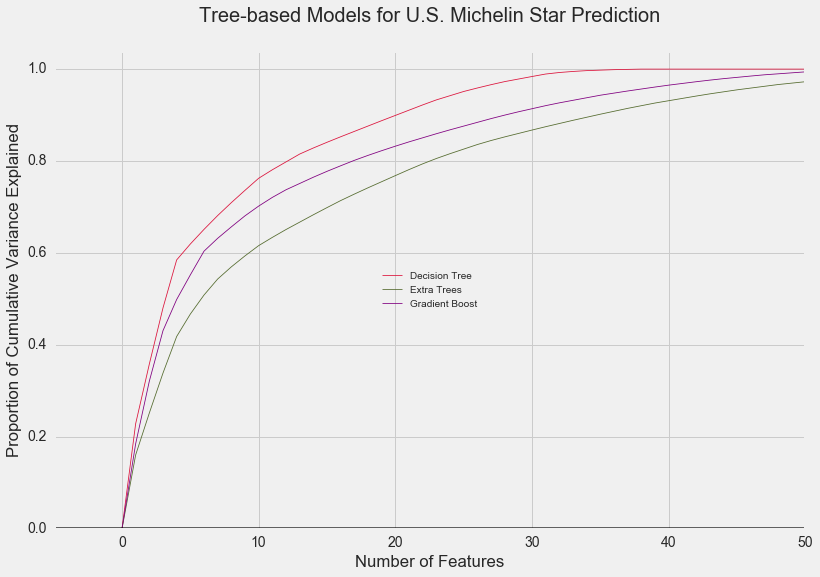

In [294]:
plt.figure(figsize=(12,8))
plt.style.use('fivethirtyeight')

plt.plot(features_gsdt.index, features_dt['sum'], color = 'Crimson', \
         linewidth = 0.8, label = 'Decision Tree')
# plt.plot(features_gsrf.index, features_rf['sum'], color = 'Orange', \
#          linewidth = 0.8, label = 'Random Forest')
plt.plot(features_gset.index, features_et['sum'], color = 'DarkOliveGreen', \
         linewidth = 0.8, label = 'Extra Trees')
# plt.plot(features_gsab.index, features_ab['sum'], color = 'blue', \
#          linewidth = 0.4, label = 'Ada Boost')
plt.plot(features_gsgb.index, features_gb['sum'], color = 'purple', \
         linewidth = 0.8, label = 'Gradient Boost')
plt.axhline(0, color='black', alpha = 0.6)
plt.title('Tree-based Models for U.S. Michelin Star Prediction', fontsize = 20, y = 1.05)

# y label
plt.ylabel('Proportion of Cumulative Variance Explained')

# x label
plt.xlabel('Number of Features', y = 0.1)

plt.xlim([-5, 50])
plt.ylim([0, 1.04])
plt.legend(loc='center', fontsize = 10)

plt.show()

In [94]:
df.columns

Index([           u'name',         u'cuisine',           u'blurb',
              u'currency',          u'photos',        u'add_info',
             u'num_words',     u'photo_count',        u'latitude',
             u'longitude',        u'name_len',         u'avg_USD',
              u'standing',           u'stars',             u'bib',
              u'included',             u'USD', u'span class=wine',
       u'english+french-',       u'old-ie.js',            u'wine',
        u'outside_dining',         u'parking',      u'wheelchair',
        u'private_dining',           u'valet',        u'osm_type',
                   u'ZIP',     u'new_cuisine',    u'adj_standing'],
      dtype='object')

In [ ]:
df[(df['cuisine'] == '') & (df['bib'] == 1)]

In [110]:
cPickle.dump(df, open('assets/big_df_model-ready.p', 'wb'))

In [3]:
df = cPickle.load(open('assets/big_df_model-ready.p', 'rb'))

In [4]:
def TheRecommender(df, cuisine, stars, max_price):
    if stars == 0:
        x = df[(df['cuisine'] == cuisine) & (df['bib'] == 1) & \
               (df['avg_USD'] <= max_price)].sort_values(by = 'adj_standing', \
                ascending = False)[['name', 'cuisine', 'blurb', 'avg_USD', 'stars', 'bib']]
        y = df[(df['cuisine'] == cuisine) & (df['included'] == 0) & \
            (df['avg_USD'] <= max_price)].sort_values(by = 'adj_standing', ascending = False)\
            [['name', 'cuisine', 'blurb', 'avg_USD', 'stars', 'bib']]
        z = pd.concat([x, y], axis = 0)
        return z
    else:
        x = df[(df['cuisine'] == cuisine) & (df['stars'] == stars) & \
               (df['avg_USD'] <= max_price)].sort_values(by = 'adj_standing', \
                ascending = False)[['name', 'cuisine', 'blurb', 'avg_USD', 'stars', 'bib']]
        return x

In [5]:
x = TheRecommender(df = df, cuisine = 'Chinese', stars = 0, max_price = 200)

In [6]:
x.iloc[1]['name']

'Yunnan Kitchen'

In [7]:
x

,name,cuisine,blurb,avg_USD,stars,bib
649,Land of Plenty,Chinese,"A sleek, clean, and subterranean space attende...",37.0,0,1
647,Yunnan Kitchen,Chinese,The Lower East Side is awash in delicious Asia...,37.0,0,1
427,East Harbor Seafood Palace,Chinese,Dim sum is a well-orchestrated dance at this b...,37.0,0,1
98,Phoenix Garden,Chinese,This fuss-free and no-frills basement joint sh...,37.0,0,1
496,Hunan Kitchen of Grand Sichuan,Chinese,As New York's Sichuan renaissance continues ap...,18.5,0,1
827,Sweet Yummy House,Chinese,"This tiny, impeccably clean dining room is dra...",37.0,0,1
644,Biáng!,Chinese,"Biáng! isn't exotic by accident. In fact, Chef...",37.0,0,1
601,Uncle Zhou,Chinese,Gifted cooks have been setting up in Elmhurst ...,18.5,0,1
543,Nom Wah Tea Parlor,Chinese,"Even after a renovation, this ""parlor"" continu...",18.5,0,1
443,Mapo Tofu,Chinese,"""How many?"" That's the greeting at this temple...",18.5,0,1


In [137]:
df[['name', 'stars', 'included', 'bib']][df['included'] == 1]

,name,stars,included,bib
0,Joe & MissesDoe,0,1,0
1,East 12th Osteria,0,1,0
2,Pagani,0,1,0
3,Armani Ristorante,0,1,0
4,Emilio's Ballato,0,1,0
6,Atrium,0,1,0
8,Toro,0,1,0
9,Narcissa,0,1,0
10,All'onda,0,1,0
11,I Sodi,0,1,0


In [159]:
df[df['stars'] == 2][['name', 'cuisine']]

,name,cuisine
113,Daniel,French
140,Aquavit,Scandinavian
220,The Modern,Contemporary
328,Soto,Japanese
342,Momofuku Ko,Contemporary
397,Marea,Seafood
575,Jungsik,Korean
623,atera,Contemporary
628,Blanca,Contemporary
744,Ichimura,Japanese


In [162]:
df[df['stars'] == 1].sort('avg_USD', ascending = True)[['name', 'cuisine']]

/Users/Rebecca/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,name,cuisine
72,Meadowsweet,Mediterranean
513,Tulsi,Indian
616,Café China,Chinese
637,Casa Enríque,Mexican
35,Somtum Der,Thai
632,La Vara,Spanish
631,Pok Pok Ny,Thai
173,Blue Hill,American
728,Uncle Boons,Thai
218,Public,Fusion


In [203]:
df.head(1)

,name,cuisine,blurb,currency,photos,add_info,num_words,photo_count,latitude,longitude,...,wine,outside_dining,parking,wheelchair,private_dining,valet,osm_type,ZIP,new_cuisine,adj_standing
0,Joe & MissesDoe,Contemporary,Chef Joe and Jill Doe have revamped their earn...,USD,[],"[$25 to $50, Brunch, Address 45 E. 1st St., Ne...",120,0,40.72379,-73.98969,...,0,0,0,0,0,0,way,10003,contemporary,12
